# Analysis of refrigerant-ethanol saturated vapour pressure measurements

Data collected by Swetha Vutlapalli - 2023

    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2023 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 28/02/2023
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
# Load required modules
import numpy as np
import scipy.optimize, scipy.integrate, scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib notebook

# Useful function to calculate R-squared.
def calcR2(f, xdata, ydata, popt):
    residuals = ydata- f(xdata, *popt)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    return 1 - (np.nansum(residuals**2) / ss_tot)

The data copied here from the spreadsheets have already been extracted from timeseries as the equilibrium conditions.

`Canister_Tcal_degC` is the bath temperature measured by RTD near the canister wall, in degrees C.

`Pressure_bar_abs` is the absolute pressure at the pressure transducer outside the bath.

`PressureTxTemp_degC` is the temperature at the pressure transducer (close to room temperature).

`NIST_Temp_degC` is the NIST REFPROP temperature of pure propellant at the pressure `Pressure_bar_abs`.

## Step 1. Check pure propellant data for any required corrections

First, let's load a plot the data obtained from experiments against NIST data. We use the measured pressure to look up the expected saturation temperature. Pascal's law requires the pressure at the transducer to deviate from the saturation pressure inside the can by no more than

$ P - \rho_v g \Delta h $ 

which for these experiments will be on the order of 10 Pa, or 0.0001 bar -- far smaller than the precision of our sensor.

The remaining pressure bias is due to the sensor calibration, and the presence of noncondensable gases in the system.

Once the pressure sensor is well calibrated, deviations between NIST and experiment will primarily be due to _temperature drift_ i.e. one end of the closed system is at room temp and the other is at the bath temp, and this sets up a temperature gradient giving a small change in the average temperature. We expect that the temperature will be 'too high' when below room temp, and 'too low' when above room temp if this is the case. There can also be *hysteresis*; sudden jumps in the signal when the direction of heat flow changes or exceeds a certain value.

In [2]:
# From Antoine Equation

def ethanol_antoine(TdegC):
    A=8.20417; B=1642.89; C=230.3; # Coeffs from internet.
    mmHg= (10**(A-(B/(C+TdegC)))) # Antoine eqn.
    mmHg[(TdegC<-57) | (TdegC>80)] = np.nan
    return mmHg * 0.00133322 # convert mmHg to bar abs.

Ethanol_SVP = {'EthanolFraction':0, 'descriptor':'Pure Ethanol SVP',\
               'NIST_Temp_degC':np.array([-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52])}
Ethanol_SVP['Pressure_bar_abs'] = ethanol_antoine(Ethanol_SVP['NIST_Temp_degC'])

In [3]:
# This is from the NIST Chemistry WebBook, SRD 69 
# https://webbook.nist.gov/cgi/fluid.cgi?TLow=-45&THigh=55&TInc=1&Digits=5&ID=C811972&Action=Load&Type=SatP&TUnit=C&PUnit=bar&DUnit=kg%2Fm3&HUnit=kJ%2Fkg&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm&RefState=DEF
HFA134a_NIST = {'EthanolFraction':0, 'descriptor':'HFA-134a Pure SVP',\
                'NIST_Temp_degC':np.array([-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52]),\
                'Pressure_bar_abs':np.array([0.39117,0.41329,0.4364,0.46055,0.48577,0.51209,0.53954,0.56817,0.59801,0.62908,0.66144,0.69512,0.73015,0.76658,0.80444,0.84378,0.88463,0.92703,0.97103,1.0167,1.064,1.113,1.1639,1.2165,1.271,1.3273,1.3857,1.446,1.5084,1.5728,1.6394,1.7082,1.7792,1.8524,1.928,2.006,2.0864,2.1693,2.2548,2.3428,2.4334,2.5268,2.6228,2.7217,2.8234,2.928,3.0356,3.1462,3.2598,3.3766,3.4966,3.6198,3.7463,3.8761,4.0094,4.1461,4.2863,4.4301,4.5776,4.7288,4.8837,5.0425,5.2052,5.3718,5.5424,5.7171,5.8959,6.0789,6.2662,6.4578,6.6538,6.8543,7.0592,7.2688,7.483,7.702,7.9257,8.1543,8.3878,8.6262,8.8698,9.1185,9.3724,9.6315,9.896,10.166,10.441,10.722,11.009,11.301,11.599,11.903,12.213,12.529,12.851,13.179,13.513,13.854])}

# This is from the NIST Chemistry WebBook, SRD 69 
# https://webbook.nist.gov/cgi/fluid.cgi?TLow=-45&THigh=55&TInc=1&Digits=5&ID=C75376&Action=Load&Type=SatP&TUnit=C&PUnit=bar&DUnit=kg%2Fm3&HUnit=kJ%2Fkg&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm&RefState=DEF
HFA152a_NIST = {'EthanolFraction':0, 'descriptor':'HFA-152a Pure SVP',\
    'NIST_Temp_degC':np.array([-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52]),\
    'Pressure_bar_abs':np.array([0.36233,0.38244,0.40344,0.42537,0.44825,0.47211,0.49699,0.52291,0.54991,0.57802,0.60727,0.63769,0.66933,0.70221,0.73636,0.77183,0.80865,0.84685,0.88647,0.92755,0.97012,1.0142,1.0599,1.1072,1.1562,1.2068,1.2592,1.3133,1.3692,1.427,1.4868,1.5484,1.612,1.6777,1.7454,1.8152,1.8872,1.9614,2.0379,2.1166,2.1977,2.2812,2.3671,2.4555,2.5464,2.6399,2.736,2.8348,2.9364,3.0407,3.1478,3.2578,3.3708,3.4867,3.6056,3.7276,3.8528,3.9811,4.1127,4.2476,4.3858,4.5274,4.6725,4.8211,4.9733,5.129,5.2885,5.4516,5.6186,5.7894,5.9641,6.1428,6.3254,6.5122,6.7031,6.8982,7.0975,7.3011,7.5091,7.7216,7.9385,8.16,8.3861,8.6168,8.8523,9.0926,9.3378,9.5879,9.843,10.103,10.368,10.639,10.915,11.196,11.482,11.774,12.071,12.374])}

# This is from NIST REFPROP 10
HFO1234_NIST = {'EthanolFraction':0, 'descriptor':'HFO-1234ze(E) Pure SVP',\
    'NIST_Temp_degC':np.array([-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55]),\
    'Pressure_bar_abs':np.array([0.27931,0.29541,0.31224,0.32985,0.34825,0.36747,0.38754,0.40848,0.43033,0.45311,0.47684,0.50157,0.52731,0.5541,0.58197,0.61094,0.64106,0.67234,0.70483,0.73855,0.77355,0.80984,0.84747,0.88647,0.92687,0.96872,1.012,1.0569,1.1032,1.1512,1.2008,1.252,1.305,1.3596,1.4161,1.4744,1.5345,1.5965,1.6604,1.7263,1.7942,1.8642,1.9363,2.0105,2.0869,2.1655,2.2464,2.3296,2.4151,2.5031,2.5934,2.6863,2.7817,2.8797,2.9803,3.0836,3.1896,3.2983,3.4099,3.5243,3.6416,3.7619,3.8851,4.0114,4.1409,4.2734,4.4092,4.5482,4.6905,4.8362,4.9852,5.1377,5.2937,5.4533,5.6164,5.7833,5.9538,6.1281,6.3062,6.4882,6.6741,6.864,7.0579,7.256,7.4581,7.6645,7.8751,8.0901,8.3094,8.5332,8.7615,8.9943,9.2317,9.4738,9.7206,9.9722,10.229,10.49,10.756,11.028,11.304])}

############

# From Excel: R152_data.xlsx Sheet E0_ R152a (Abs. Transducer)
HFA152a_E0A = {'Canister_Tcal_degC':np.array([52.57572167,47.50266015,42.49312543,37.50198775,32.50150759,27.49301665,22.40212251,17.39894866,12.2667684,7.162201723,2.007622342,-2.620682715,-7.507531664,-12.73091152,-17.8730646,-25.66495233,-33.8375149,-46.06863721]),\
              'Pressure_bar_abs':np.array([12.31401093,10.84006898,9.537076399,8.346442156,7.271541578,6.344051768,5.554963806,4.786223815,3.971836751,3.399220836,2.888719428,2.480584312,2.103013446,1.768236418,1.466668006,1.134602181,0.856330984,0.560450771]),\
              'PressureTxTemp_degC':np.array([21.75357388,21.66452113,21.65967504,21.40394908,21.88688369,22.13289817,22.50123228,21.92886689,21.59239734,21.82841597,21.89118436,21.71908785,21.4909228,21.3992574,20.86355092,20.9644198,20.96482596,20.3047787]),\
              'EthanolFraction':0, 'NIST':HFA152a_NIST,\
              'NIST_Temp_degC':np.array([51.803,46.732,41.798,36.826,31.856,27.101,22.622,17.767,11.928,7.248,2.534,-1.7211,-6.1707,-10.67,-15.333,-21.436,-27.757,-36.62])}


# From Excel: R152_data.xlsx Sheet E0_ R152a (Gauge Transducer)
HFA152a_E0G = {'Canister_Tcal_degC':np.array([48.8848414,44.01226842,39.95056592,34.25869398,29.3190617,24.40861938,19.41601687,14.49854318,9.608204626,4.561030461,-0.634246118,-5.818212433,-10.9971881,-16.12671794,-21.43460601,-31.81816993,-31.73930286]),\
              'Pressure_bar_abs':np.array([11.14451386,9.959257584,8.805471772,7.766803894,6.883583113,6.243091766,5.628263117,5.152465472,4.769877463,4.186257481,3.657985532,3.202304232,2.804494491,2.450459986,2.154351933,1.690152524,1.619884065]),\
              'PressureTxTemp_degC':np.array([20.60156027,20.43746945,20.47060608,20.71326277,20.70765698,20.98216756,21.24689863,21.55858422,22.64608025,22.47152675,22.34566299,22.09353573,22.11604625,20.67586619,20.76511243,22.69120437,21.47662322]),\
              'EthanolFraction':0, 'NIST':HFA152a_NIST,\
              'NIST_Temp_degC':np.array([47.82,43.449,38.803,34.21,29.926,26.552,23.057,20.148,17.658,13.548,9.4323,5.4986,1.6958,-2.056,-5.531,-11.813,-12.879])}

# From Excel: R1234_data.xlsx sheet E0_Abs
HFO1234_E0A = {'Canister_Tcal_degC':np.array([50.42424128,45.3579576,40.37284869,35.33388687,30.27645651,25.25014253,20.05670481,15.00820146,9.916052654,4.805107097,-0.32836189,-5.438458582,-10.65343371,-15.78068035,-21.10803456,-31.23532025,-36.15046224]),\
              'Pressure_bar_abs':np.array([9.82922241,8.607314639,7.521649068,6.536222659,5.64783779,4.855120142,4.129371814,3.54571022,2.985239491,2.493972813,2.062242691,1.690439851,1.369027114,1.097896291,0.866413188,0.55179743,0.440811029]),\
              'PressureTxTemp_degC':np.array([22.93343744,23.11644592,23.19205541,22.65905557,22.41673411,22.20958985,20.92563378,20.79681498,20.832199,20.66205291,21.02035058,21.93125125,21.66326656,21.10134526,20.49236489,22.99092962,20.57125824]),\
              'EthanolFraction':0, 'NIST':HFO1234_NIST,\
              'NIST_Temp_degC':np.array([49.434,44.327,39.31,34.26,29.19,24.129,18.912,14.185,9.0485,3.898,-1.3194,-6.5405,-11.832,-17.114,-22.51,-32.084,-36.535])}
        
# From Excel: R1234_data.xlsx sheet E0_Gauge
HFO1234_E0G = {'Canister_Tcal_degC':np.array([47.79029443,43.09544947,38.37098082,33.50201449,28.74711201,23.91020363,19.02855507,14.20818349,9.204952047,4.22556571,-10.94752157,-21.38336195,-32.38342561]),\
              'Pressure_bar_abs':np.array([9.1291929,8.046869596,7.07583776,6.173347135,5.376114411,4.645837118,3.98395386,3.399999984,2.869414322,2.361775263,1.318504826,0.84758743,0.521845577]),\
              'PressureTxTemp_degC':np.array([19.98814352,19.96897854,19.87192322,19.95127517,19.88007723,19.96211754,20.08030928,20.012007,20.08763725,20.0513903,20.37394701,20.53897198,21.19815183]),\
              'EthanolFraction':0, 'NIST':HFO1234_NIST,\
              'NIST_Temp_degC':np.array([46.571,41.801,37.091,32.256,27.519,22.689,17.784,12.913,7.8963,2.3797,-12.749,-22.997,-33.209])}


# From Excel: R134a_Data.xlsx sheet E0_Abs
HFA134a_E0A = {'Canister_Tcal_degC':np.array([45.0751983856502,43.1144780201342,39.9539653768844,35.0472739698492,30.0023115075377,24.9404889699571,19.9794003015075,15.1966550166667,10.1292557328881,5.07868225125628,-0.0549436951934784,-5.34722713744076,-10.5408748322148,-15.5554355704698,-20.7334544723618,-31.2053038461538,-35.3500227852349,-45.0611916778524]),\
              'Pressure_bar_abs':np.array([11.5748169140713,11.0020521553535,10.117384697207,8.84749801525983,7.66060568324867,6.557630890132,5.61446346692992,4.79154994740464,4.06163082902308,3.41490853219618,2.84207338243303,2.30068786789315,1.87476859848694,1.5164861541495,1.21979418770893,0.775092252617682,0.641213588678933,0.396637004953357]),\
              'PressureTxTemp_degC':np.array([20.344996004661,20.3907682196339,20.3698876871881,20.4177159733778,20.4716549084858,20.530767720466,20.6539963357765,21.2208254575706,21.550981031614,21.7066552412647,21.7221970353103,20.3583560942304,20.3584149398395,20.5345550748748,21.0788565007494,22.7563939445484,22.0636332778703,20.569736439268]),\
              'EthanolFraction':0, 'NIST':HFA134a_NIST,\
              'NIST_Temp_degC':np.array([44.919,42.976,39.822,34.909,29.813,24.512,19.416,14.408,9.3854,4.3221,-0.81954,-6.4745,-11.701,-16.872,-21.938,-31.772,-35.62,-44.749])}

# From Excel: R134a_Data.xlsx sheet E0_Gauge
HFA134a_E0G = {'Canister_Tcal_degC':np.array([46.2906965058236,43.4102206833333,38.5832405823627,33.7226654076539,28.8835392845258,23.9898911813644,19.1008880333333,14.1378155574043,9.16084386688851,4.15805582695508,-0.984913402163061,-11.177237437604,-21.5844904159734]),\
              'Pressure_bar_abs':np.array([11.7442187973627,10.9419133224568,9.69903426121859,8.64125936421844,7.80631966621439,6.93030227816001,6.3199291086176,5.67572778476274,5.15097909024316,4.56635746567742,4.03990024722764,3.1827945883553,2.47727956189688]),\
              'PressureTxTemp_degC':np.array([22.361316394535,22.3665888240201,22.3679214668454,22.238760873188,22.3373049065422,22.0375999666219,21.8980080000003,20.7156608344551,20.6891977325776,20.6732522943433,21.0471174311925,21.3917104472629,20.5893279399499]),\
              'EthanolFraction':0, 'NIST':HFA134a_NIST,\
              'NIST_Temp_degC':np.array([45.479,42.768,38.257,34.062,30.469,26.374,23.283,19.765,16.67,12.925,9.2257,2.3251,-4.5265])}


<IPython.core.display.Javascript object>


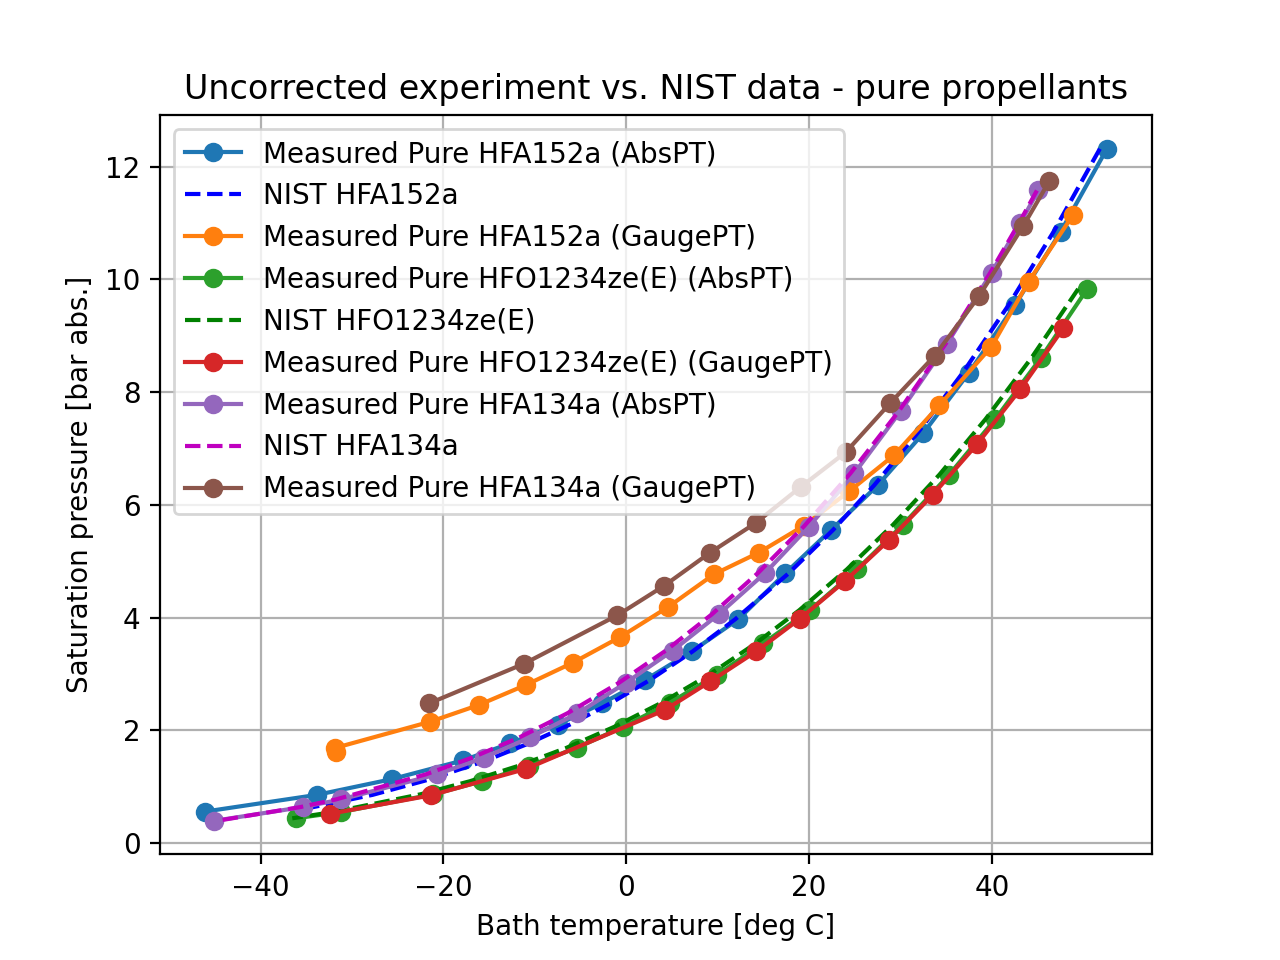

In [4]:
fig=plt.figure()
plt.title("Uncorrected experiment vs. NIST data - pure propellants")
plt.grid(); plt.xlabel('Bath temperature [deg C]'); plt.ylabel('Saturation pressure [bar abs.]')

plt.plot(HFA152a_E0A['Canister_Tcal_degC'], HFA152a_E0A['Pressure_bar_abs'],marker='o',label='Measured Pure HFA152a (AbsPT)')
plt.plot(HFA152a_E0A['NIST_Temp_degC'], HFA152a_E0A['Pressure_bar_abs'],label='NIST HFA152a',ls='--',c='b')
plt.plot(HFA152a_E0G['Canister_Tcal_degC'], HFA152a_E0G['Pressure_bar_abs'],marker='o',label='Measured Pure HFA152a (GaugePT)')

plt.plot(HFO1234_E0A['Canister_Tcal_degC'], HFO1234_E0A['Pressure_bar_abs'],marker='o',label='Measured Pure HFO1234ze(E) (AbsPT)')
plt.plot(HFO1234_E0A['NIST_Temp_degC'], HFO1234_E0A['Pressure_bar_abs'],label='NIST HFO1234ze(E)',ls='--',c='g')
plt.plot(HFO1234_E0G['Canister_Tcal_degC'], HFO1234_E0G['Pressure_bar_abs'],marker='o',label='Measured Pure HFO1234ze(E) (GaugePT)')

plt.plot(HFA134a_E0A['Canister_Tcal_degC'], HFA134a_E0A['Pressure_bar_abs'],marker='o',label='Measured Pure HFA134a (AbsPT)')
plt.plot(HFA134a_E0A['NIST_Temp_degC'], HFA134a_E0A['Pressure_bar_abs'],label='NIST HFA134a',ls='--',c='m')
plt.plot(HFA134a_E0G['Canister_Tcal_degC'], HFA134a_E0G['Pressure_bar_abs'],marker='o',label='Measured Pure HFA134a (GaugePT)')


plt.legend();

## 2. Check Gauge PT data for correct subtraction of the atmospheric pressure

<IPython.core.display.Javascript object>


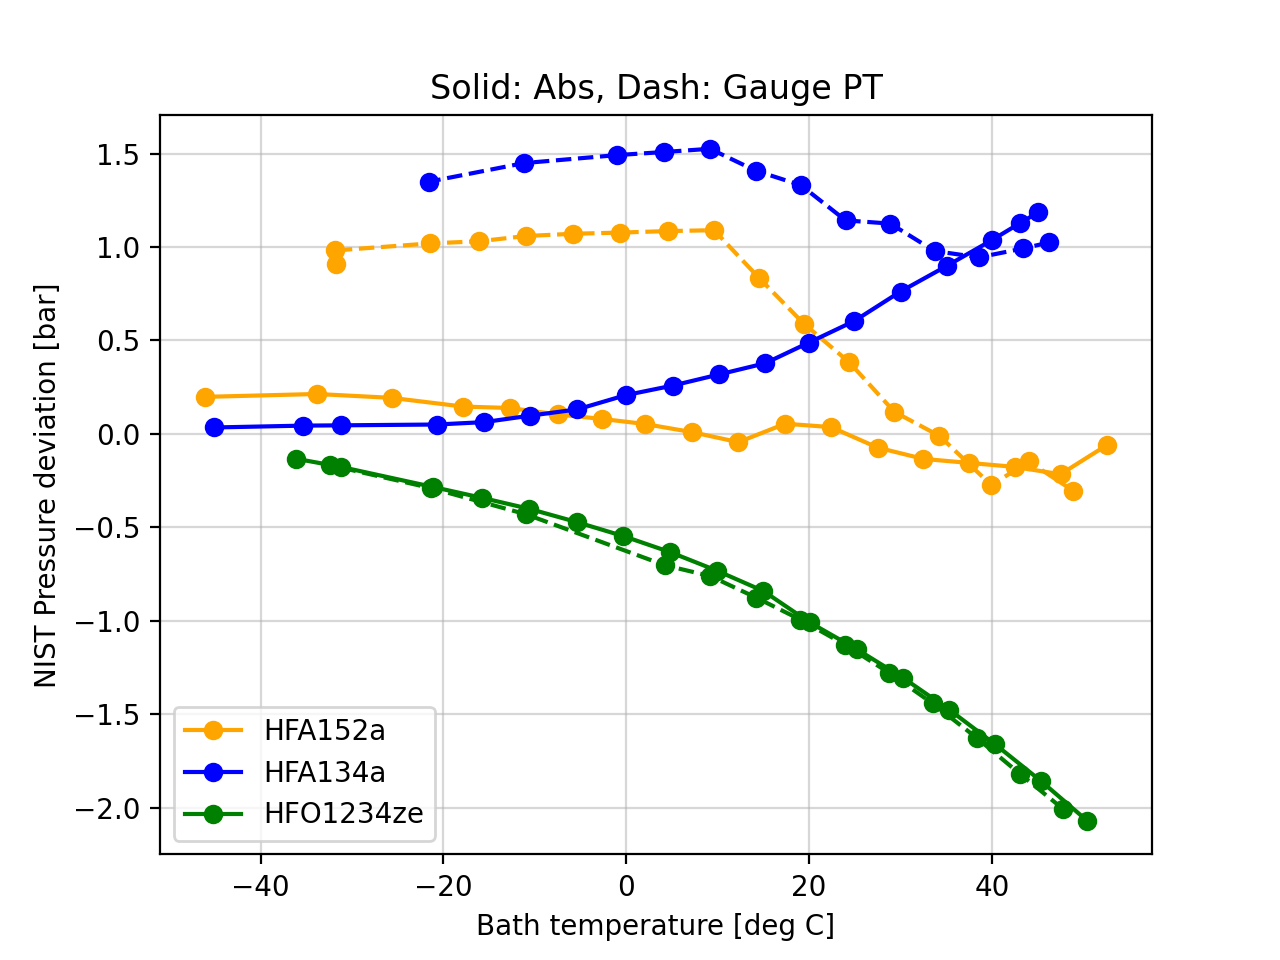

In [5]:
fig=plt.figure()
plt.grid(alpha=.5)
plt.xlabel('Bath temperature [deg C]')
plt.ylabel('NIST Pressure deviation [bar]')
cList=['orange','b','g']; n=0

for datasetG,datasetA,label in [(HFA152a_E0G,HFA152a_E0A,'HFA152a'),\
                      (HFA134a_E0G,HFA134a_E0A,'HFA134a'),\
                      (HFO1234_E0G,HFO1234_E0A,'HFO1234ze')]:
    
    # Compute pressure deviation from NIST by interpolation
    NIST_Pressure_A = np.interp(datasetA['Canister_Tcal_degC'],HFA152a_NIST['NIST_Temp_degC'],\
                              HFA152a_NIST['Pressure_bar_abs'])

    NIST_Pressure_G = np.interp(datasetG['Canister_Tcal_degC'],HFA152a_NIST['NIST_Temp_degC'],\
                              HFA152a_NIST['Pressure_bar_abs'])

    
    Pressure_Deviation_A = datasetA['Pressure_bar_abs']-NIST_Pressure_A
    Pressure_Deviation_G = datasetG['Pressure_bar_abs']-NIST_Pressure_G
    Temp_A = datasetA['Canister_Tcal_degC']
    Temp_G = datasetG['Canister_Tcal_degC']

    plt.plot(Temp_A, Pressure_Deviation_A,marker='o',label=label,c=cList[n])
    plt.plot(Temp_G, Pressure_Deviation_G,marker='o',ls='--',c=cList[n],label=None)
    n+=1

plt.legend();
plt.title('Solid: Abs, Dash: Gauge PT')
plt.savefig('/Users/dduke/Desktop/PT_error.png')

The above result shows a smooth temperature-dependent deviation for the HFO1234ze which is independent of choice of pressure transducer. The error goes toward zero at low temperature, so it is likely a temperature-dependent bias that can be corrected. 

For the other two propellants significant difference is seen between A and G transducers, indicating a problem with the transducer.  The absolute sensor lines appear smooth, so these are also likely OK. We need to make a correction for all the 152a and 134a gauge PT readings because these are clearly far too high. 

<IPython.core.display.Javascript object>


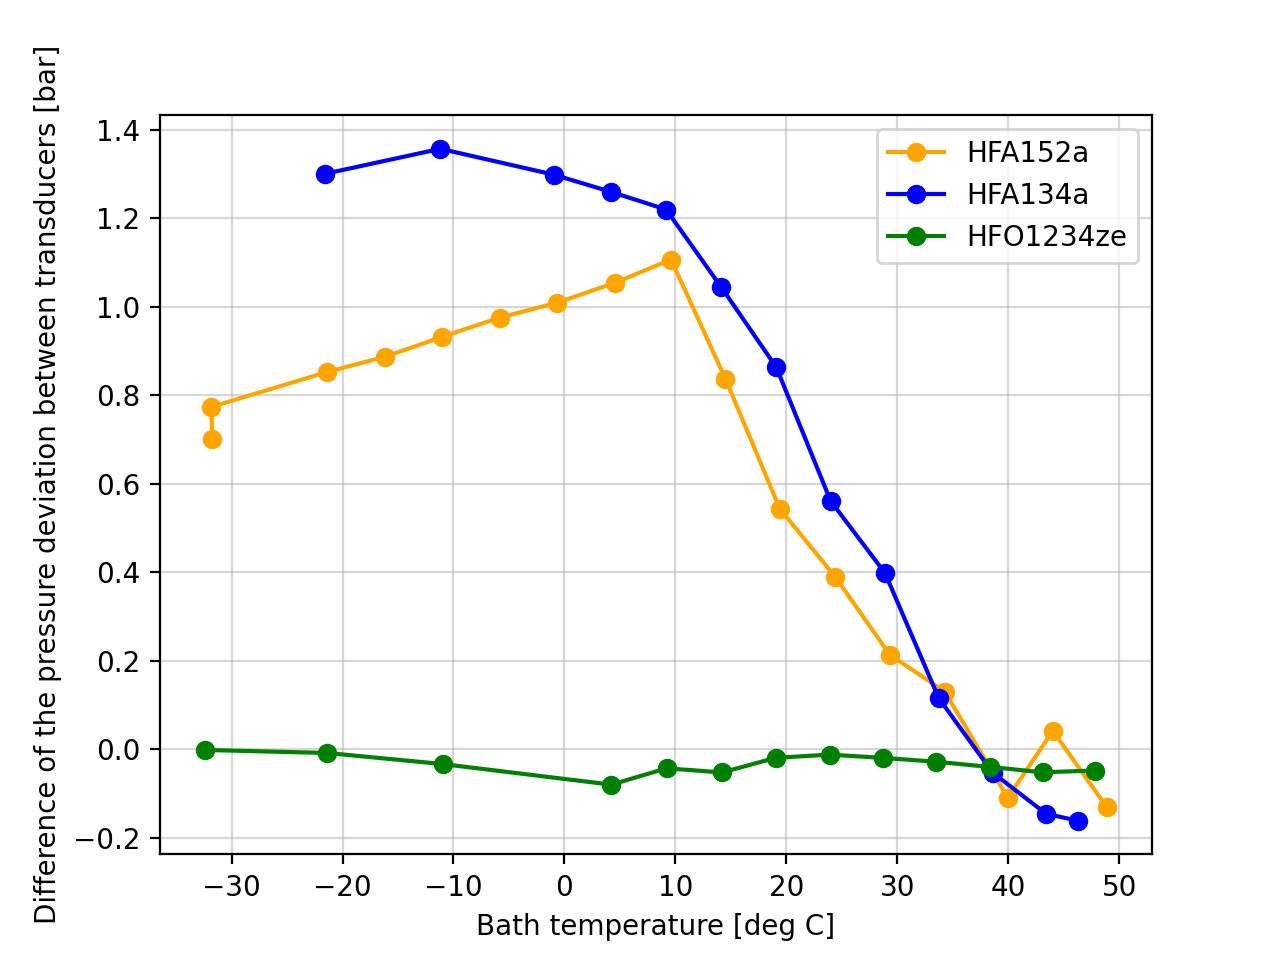

In [67]:
def pressureCorrectionFunction(T,a,b,c,d,e):
    return  a+b*T+c*T**2+d*T**3+e*T**4

######################################################################
fig=plt.figure()
plt.grid(alpha=.5)
plt.xlabel('Bath temperature [deg C]')
cList=['orange','b','g']; n=0

for datasetG,datasetA,label in [(HFA152a_E0G,HFA152a_E0A,'HFA152a'),\
                      (HFA134a_E0G,HFA134a_E0A,'HFA134a'),\
                      (HFO1234_E0G,HFO1234_E0A,'HFO1234ze')]:
    
    # Compute pressure deviation from NIST by interpolation
    NIST_Pressure_A = np.interp(datasetA['Canister_Tcal_degC'],HFA152a_NIST['NIST_Temp_degC'],\
                              HFA152a_NIST['Pressure_bar_abs'])

    NIST_Pressure_G = np.interp(datasetG['Canister_Tcal_degC'],HFA152a_NIST['NIST_Temp_degC'],\
                              HFA152a_NIST['Pressure_bar_abs'])
    
    Pressure_Deviation_A = datasetA['Pressure_bar_abs']-NIST_Pressure_A
    Pressure_Deviation_G = datasetG['Pressure_bar_abs']-NIST_Pressure_G
    
    Temp_A = datasetA['Canister_Tcal_degC']
    Temp_G = datasetG['Canister_Tcal_degC']

    # Interpolate the absolute pressure deviation (good) onto the gauge pressure (bad?)
    PDAi = np.interp(Temp_G[::-1], Temp_A[::-1], Pressure_Deviation_A[::-1])[::-1]
    
    # Difference between transducers
    Pressure_Deviation_Difference = Pressure_Deviation_G-PDAi
    
    # Plot.
    plt.plot(Temp_G, Pressure_Deviation_Difference, marker='o',label=label,c=cList[n])

    # Fit correction?
    if np.any(np.abs(Pressure_Deviation_Difference)>99.25):
    
        # Fit to this
        
        popt, pcov = scipy.optimize.curve_fit(pressureCorrectionFunction, Temp_G, Pressure_Deviation_Difference )

        # Save fit where required
        datasetG['Pressure_Correction_Popt'] = popt
        datasetG['Pressure_Correction'] = pressureCorrectionFunction(Temp_G,*popt)
    
        T_ = np.linspace(Temp_G.min(),Temp_G.max(),100)
        plt.plot(T_,pressureCorrectionFunction(T_,*popt),ls='-.',lw=1,label='Fit')
    
    else:
        datasetG['Pressure_Correction_Popt'] = None
        datasetG['Pressure_Correction'] = np.zeros_like(Temp_G)
        
    # Never correct absolute sensor/
    datasetA['Pressure_Correction_Popt'] = None 
    datasetA['Pressure_Correction'] = np.zeros_like(Temp_A)
        
    n+=1
  
plt.legend();
plt.ylabel('Difference of the pressure deviation between transducers [bar]');

## 3. Develop a correction function for the remaining temperature deviation

Remaining error is now in the temperature due to the sensor being at room temp and not equal to the bath temp.

The correction will likely need to increase somewhat proportionally to the difference between the temperature in the bath and at the pressure transducer (ie the magnitude of the gradient in temperature). Let's plot the error between NIST and measured temperature against the temperature gradient in the system, allowing for the ncg pressure correction in doing so.

<IPython.core.display.Javascript object>


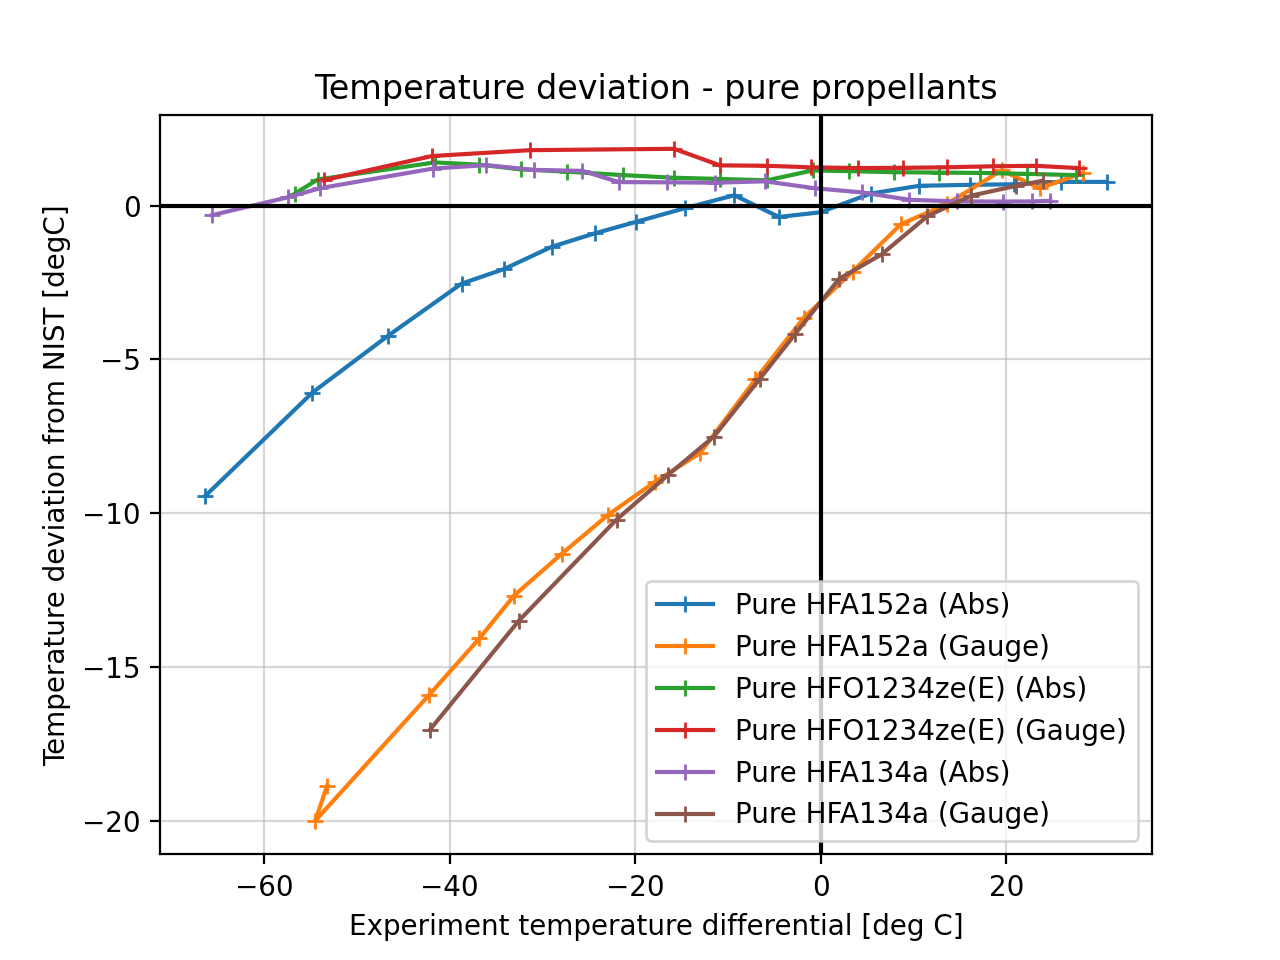

In [68]:
# Recompute the NIST equivalent temperature accounting for the ncg partial pressure
NIST_Temp_152aA = np.interp(HFA152a_E0A['Pressure_bar_abs']-HFA152a_E0A['Pressure_Correction'],\
                           HFA152a_NIST['Pressure_bar_abs'],HFA152a_NIST['NIST_Temp_degC'])

NIST_Temp_152aG = np.interp(HFA152a_E0G['Pressure_bar_abs']-HFA152a_E0G['Pressure_Correction'],\
                           HFA152a_NIST['Pressure_bar_abs'],HFA152a_NIST['NIST_Temp_degC'])

NIST_Temp_1234zeA = np.interp(HFO1234_E0A['Pressure_bar_abs']-HFO1234_E0A['Pressure_Correction'],\
                           HFO1234_NIST['Pressure_bar_abs'],HFO1234_NIST['NIST_Temp_degC'])

NIST_Temp_1234zeG = np.interp(HFO1234_E0G['Pressure_bar_abs']-HFO1234_E0G['Pressure_Correction'],\
                           HFO1234_NIST['Pressure_bar_abs'],HFO1234_NIST['NIST_Temp_degC'])

NIST_Temp_134aA = np.interp(HFA134a_E0A['Pressure_bar_abs']-HFA134a_E0A['Pressure_Correction'],\
                           HFA134a_NIST['Pressure_bar_abs'],HFA134a_NIST['NIST_Temp_degC'])

NIST_Temp_134aG = np.interp(HFA134a_E0G['Pressure_bar_abs']-HFA134a_E0G['Pressure_Correction'],\
                           HFA134a_NIST['Pressure_bar_abs'],HFA134a_NIST['NIST_Temp_degC'])

# Compute differences

Tdiff_152aA = HFA152a_E0A['Canister_Tcal_degC']-HFA152a_E0A['PressureTxTemp_degC']
Tdev_152aA =  HFA152a_E0A['Canister_Tcal_degC']-NIST_Temp_152aA #HFA152a_E0A['NIST_Temp_degC']

Tdiff_152aG = HFA152a_E0G['Canister_Tcal_degC']-HFA152a_E0G['PressureTxTemp_degC']
Tdev_152aG =  HFA152a_E0G['Canister_Tcal_degC']-NIST_Temp_152aG #-HFA152a_E0G['NIST_Temp_degC']

Tdiff_1234zeA = HFO1234_E0A['Canister_Tcal_degC']-HFO1234_E0A['PressureTxTemp_degC']
Tdev_1234zeA = HFO1234_E0A['Canister_Tcal_degC']-NIST_Temp_1234zeA #HFO1234_E0A['NIST_Temp_degC']

Tdiff_1234zeG = HFO1234_E0G['Canister_Tcal_degC']-HFO1234_E0G['PressureTxTemp_degC']
Tdev_1234zeG = HFO1234_E0G['Canister_Tcal_degC']-NIST_Temp_1234zeG #HFO1234_E0G['NIST_Temp_degC']

Tdiff_134aA = HFA134a_E0A['Canister_Tcal_degC']-HFA134a_E0A['PressureTxTemp_degC']
Tdev_134aA = HFA134a_E0A['Canister_Tcal_degC']-NIST_Temp_134aA #HFA134a_E0A['NIST_Temp_degC']

Tdiff_134aG = HFA134a_E0G['Canister_Tcal_degC']-HFA134a_E0G['PressureTxTemp_degC']
Tdev_134aG = HFA134a_E0G['Canister_Tcal_degC']-NIST_Temp_134aG #HFA134a_E0A['NIST_Temp_degC']


# Make graph
fig=plt.figure()
plt.title("Temperature deviation - pure propellants")
plt.grid(alpha=.5); plt.xlabel('Experiment temperature differential [deg C]')
plt.ylabel('Temperature deviation from NIST [degC]')
plt.plot(Tdiff_152aA, Tdev_152aA ,marker='+',label='Pure HFA152a (Abs)')
plt.plot(Tdiff_152aG, Tdev_152aG ,marker='+',label='Pure HFA152a (Gauge)')
plt.plot(Tdiff_1234zeA, Tdev_1234zeA,marker='+',label='Pure HFO1234ze(E) (Abs)')
plt.plot(Tdiff_1234zeG, Tdev_1234zeG,marker='+',label='Pure HFO1234ze(E) (Gauge)')
plt.plot(Tdiff_134aA, Tdev_134aA,marker='+',label='Pure HFA134a (Abs)')
plt.plot(Tdiff_134aG, Tdev_134aG,marker='+',label='Pure HFA134a (Gauge)')
plt.axvline(0,c='k'); plt.axhline(0,c='k')
plt.legend();
#plt.savefig("/Users/dduke/Desktop/Tdeviation.pdf");

Let's try and fit a function to these curves that accounts for the hysteresis (discontinuity) that can occur near differential of 0 degrees (ie. where the temperature gradient from one end of the pipe to the other changes direction, and thus the magnitude of the thermal conductivity might change.

<IPython.core.display.Javascript object>


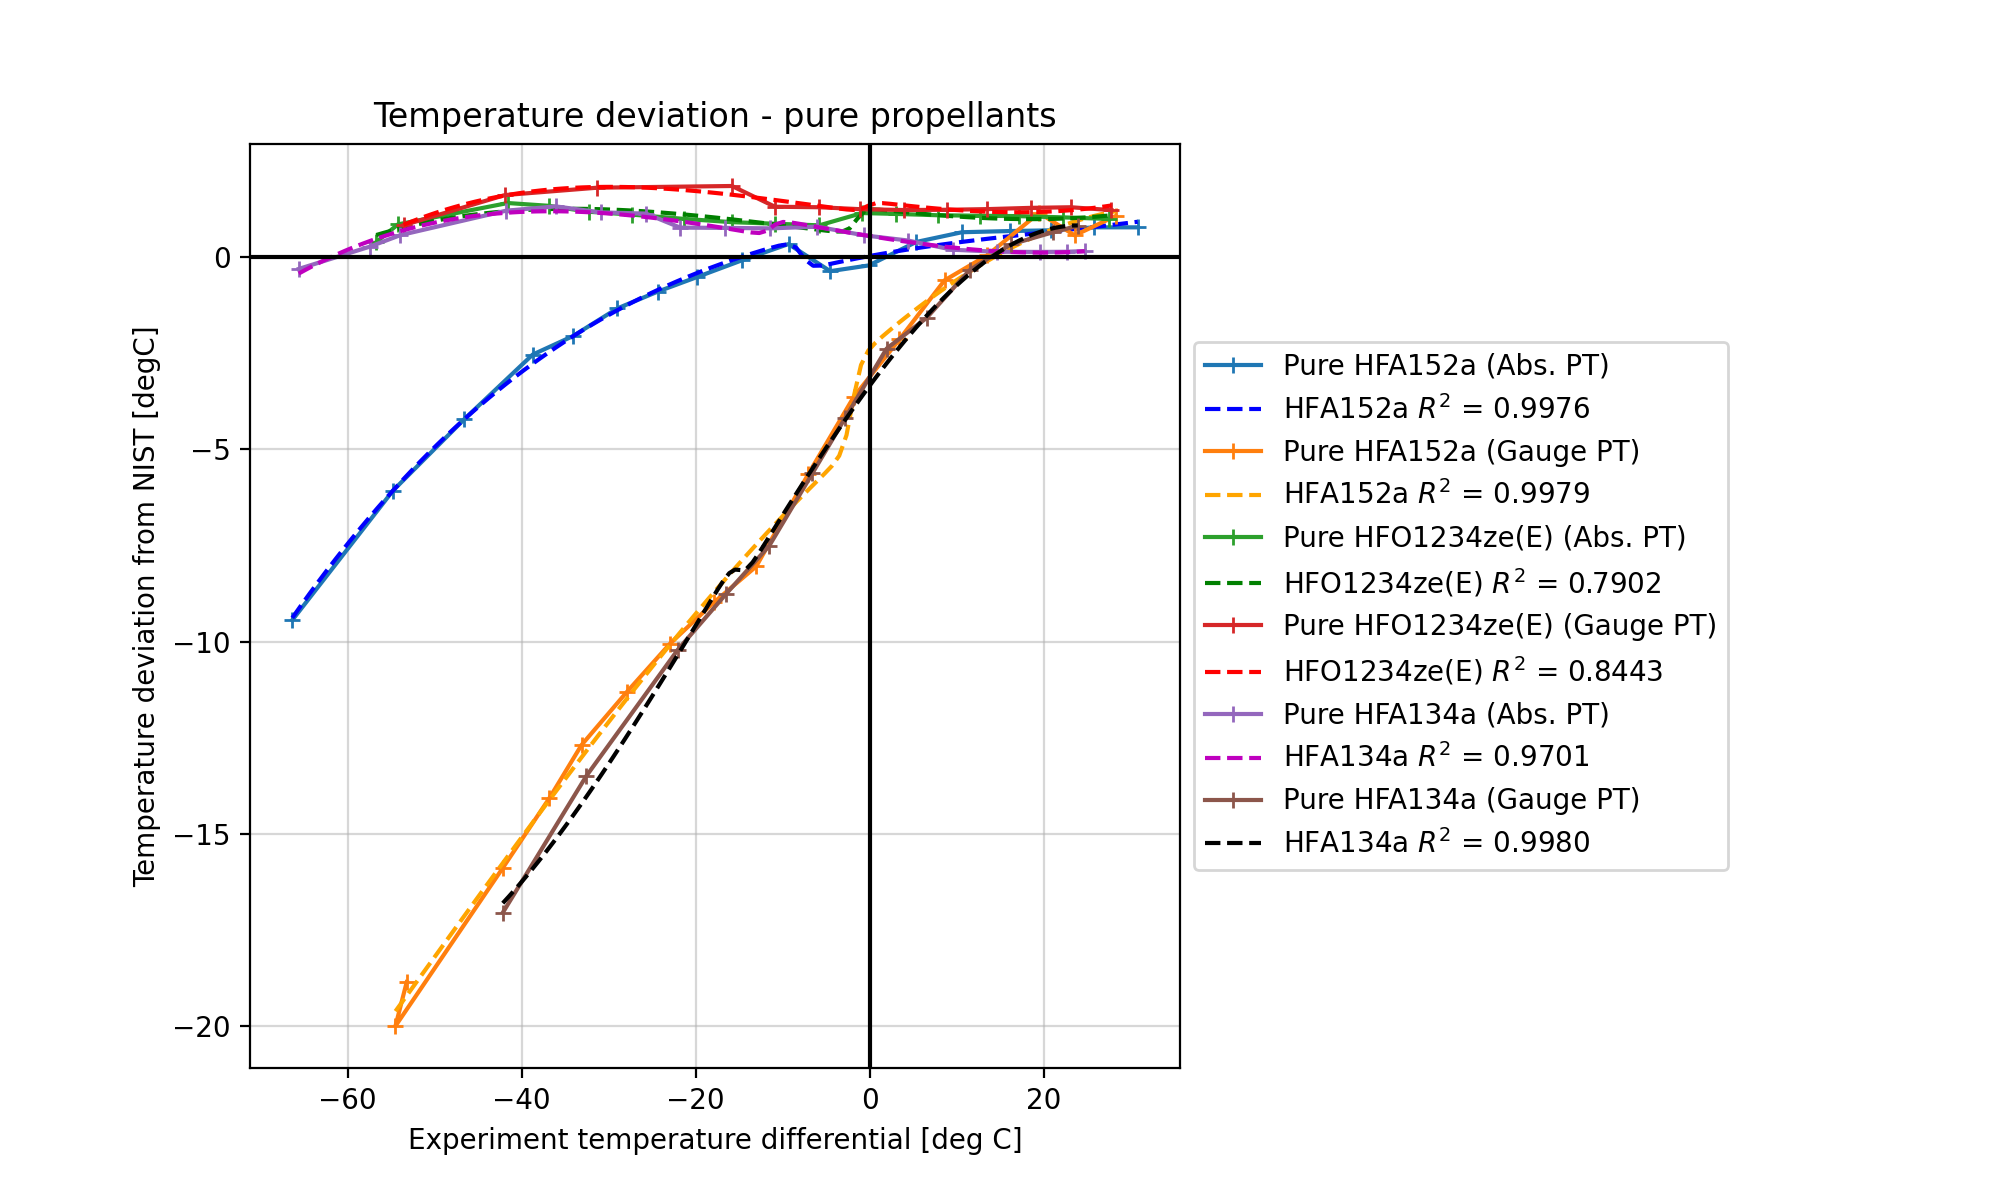

In [69]:
# An empirical function I made up.
def temperatureCorrectionFunction(Tdiff, a, b, c, d, e, dT1, dT0):

    # guardrails
    if c==0: c+=1e-6
    if dT1==0: dT1=1e-2
    dT2=1.0
    
    a=0
    linearCorrection = a*Tdiff**4 + b*Tdiff**3 + c*Tdiff**2 + d*Tdiff + e
    
    if dT0<-15:dT0=-15
    nonlinearCorrection = -dT1*(np.tanh(dT2*(Tdiff+np.abs(dT0)))*0.5 + 0.5)
    
    return linearCorrection + nonlinearCorrection


# Run curve fitting (least squares)
popt1A, pcov1A = scipy.optimize.curve_fit(temperatureCorrectionFunction,Tdiff_152aA,Tdev_152aA)
r2_1A = calcR2(temperatureCorrectionFunction,Tdiff_152aA,Tdev_152aA,popt1A)
Td1A = np.linspace(Tdiff_152aA.min(),Tdiff_152aA.max(),100)

popt1G, pcov1G = scipy.optimize.curve_fit(temperatureCorrectionFunction,Tdiff_152aG,Tdev_152aG)
r2_1G = calcR2(temperatureCorrectionFunction,Tdiff_152aG,Tdev_152aG,popt1G)
Td1G = np.linspace(Tdiff_152aG.min(),Tdiff_152aG.max(),100)

popt2A, pcov2A = scipy.optimize.curve_fit(temperatureCorrectionFunction,Tdiff_1234zeA,Tdev_1234zeA)
r2_2A = calcR2(temperatureCorrectionFunction,Tdiff_1234zeA,Tdev_1234zeA,popt2A)
Td2A = np.linspace(Tdiff_1234zeA.min(),Tdiff_1234zeA.max(),100)

popt2G, pcov2G = scipy.optimize.curve_fit(temperatureCorrectionFunction,Tdiff_1234zeG,Tdev_1234zeG)
r2_2G = calcR2(temperatureCorrectionFunction,Tdiff_1234zeG,Tdev_1234zeG,popt2G)
Td2G = np.linspace(Tdiff_1234zeG.min(),Tdiff_1234zeG.max(),100)

popt3A, pcov3A = scipy.optimize.curve_fit(temperatureCorrectionFunction,Tdiff_134aA,Tdev_134aA)
r2_3A = calcR2(temperatureCorrectionFunction,Tdiff_134aA,Tdev_134aA,popt3A)
Td3A = np.linspace(Tdiff_134aA.min(),Tdiff_134aA.max(),100)

popt3G, pcov3G = scipy.optimize.curve_fit(temperatureCorrectionFunction,Tdiff_134aG,Tdev_134aG)
r2_3G = calcR2(temperatureCorrectionFunction,Tdiff_134aG,Tdev_134aG,popt3G)
Td3G = np.linspace(Tdiff_134aG.min(),Tdiff_134aG.max(),100)


fig=plt.figure(figsize=(10,6))
plt.title("Temperature deviation - pure propellants")
plt.grid(alpha=.5); plt.xlabel('Experiment temperature differential [deg C]'); plt.ylabel('Temperature deviation from NIST [degC]')

plt.plot(Tdiff_152aA, Tdev_152aA ,marker='+',label='Pure HFA152a (Abs. PT)')
plt.plot(Td1A, temperatureCorrectionFunction(Td1A, *popt1A), ls='--',c='b',label='HFA152a $R^2$ = %.4f' % r2_1A)

plt.plot(Tdiff_152aG, Tdev_152aG ,marker='+',label='Pure HFA152a (Gauge PT)')
plt.plot(Td1G, temperatureCorrectionFunction(Td1G, *popt1G), ls='--',c='orange',label='HFA152a $R^2$ = %.4f' % r2_1G)

plt.plot(Tdiff_1234zeA, Tdev_1234zeA,marker='+',label='Pure HFO1234ze(E) (Abs. PT)')
plt.plot(Td2A, temperatureCorrectionFunction(Td2A, *popt2A), ls='--',c='g',label='HFO1234ze(E) $R^2$ = %.4f' % r2_2A)

plt.plot(Tdiff_1234zeG, Tdev_1234zeG,marker='+',label='Pure HFO1234ze(E) (Gauge PT)')
plt.plot(Td2G, temperatureCorrectionFunction(Td2G, *popt2G), ls='--',c='r',label='HFO1234ze(E) $R^2$ = %.4f' % r2_2G)

plt.plot(Tdiff_134aA, Tdev_134aA,marker='+',label='Pure HFA134a (Abs. PT)')
plt.plot(Td3A, temperatureCorrectionFunction(Td3A, *popt3A), ls='--',c='m',label='HFA134a $R^2$ = %.4f' % r2_3A)

plt.plot(Tdiff_134aG, Tdev_134aG,marker='+',label='Pure HFA134a (Gauge PT)')
plt.plot(Td3G, temperatureCorrectionFunction(Td3G, *popt3G), ls='--',c='k',label='HFA134a $R^2$ = %.4f' % r2_3G)


plt.axvline(0,c='k'); plt.axhline(0,c='k')

ax=plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Now plot again with the correction function applied:

<IPython.core.display.Javascript object>


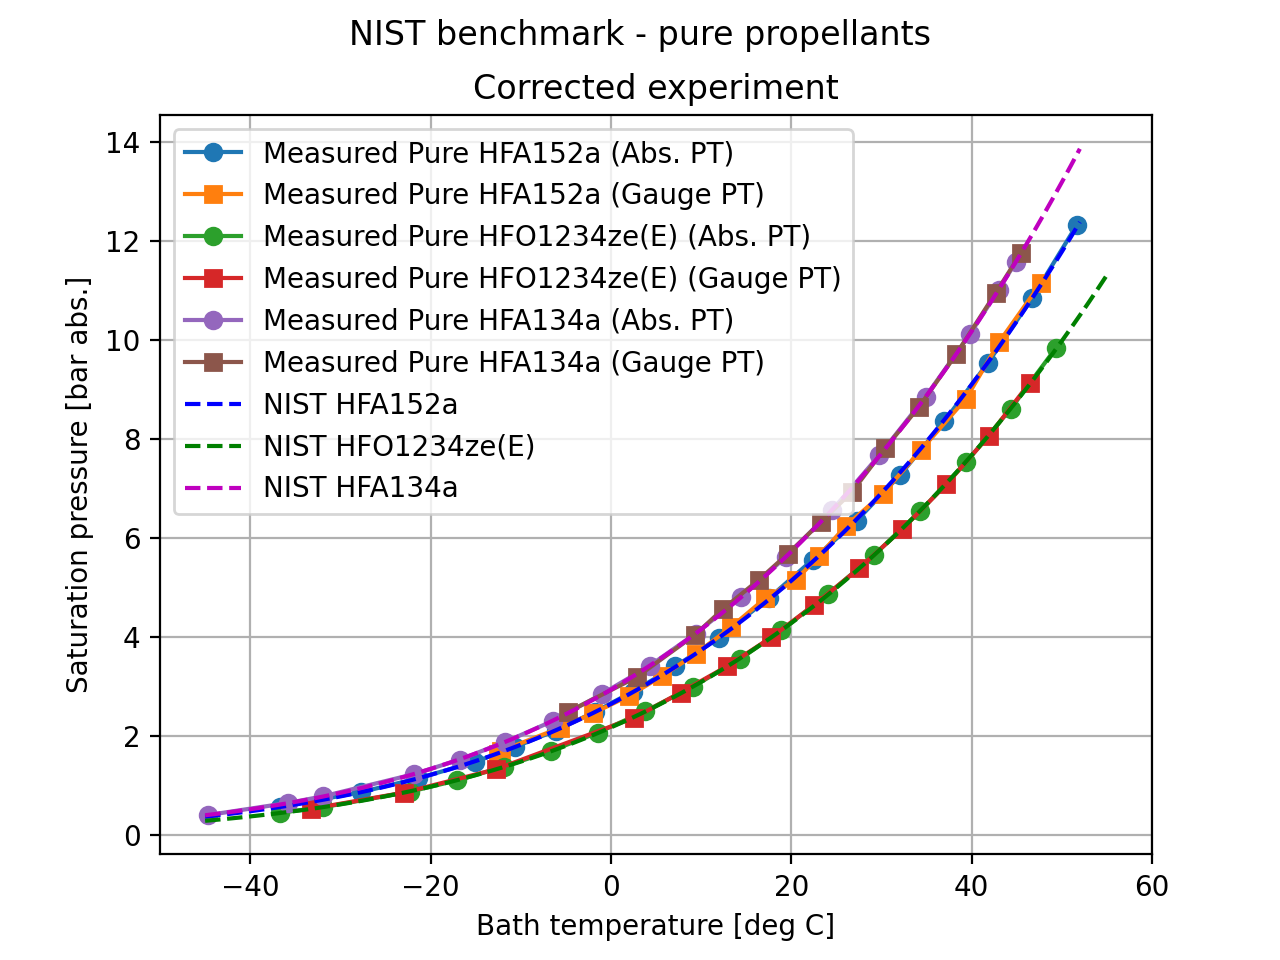

In [70]:
fig=plt.figure()
plt.suptitle("NIST benchmark - pure propellants")

# Note that Tdiff_152a is the same data point as plotted here, so no need to recalculate temperature differential.
# If using on other dataset ie ethanol-containing mixture, would need to recalc Tdiff.
ax=fig.add_subplot(111)
plt.title("Corrected experiment")
plt.grid(); plt.xlabel('Bath temperature [deg C]'); plt.ylabel('Saturation pressure [bar abs.]')

ax.plot(HFA152a_E0A['Canister_Tcal_degC']-temperatureCorrectionFunction(Tdiff_152aA,*popt1A),\
        HFA152a_E0A['Pressure_bar_abs']-HFA152a_E0A['Pressure_Correction'],\
        marker='o',label='Measured Pure HFA152a (Abs. PT)')

ax.plot(HFA152a_E0G['Canister_Tcal_degC']-temperatureCorrectionFunction(Tdiff_152aG,*popt1G),\
        HFA152a_E0G['Pressure_bar_abs']-HFA152a_E0G['Pressure_Correction'],\
        marker='s',label='Measured Pure HFA152a (Gauge PT)')

ax.plot(HFO1234_E0A['Canister_Tcal_degC']-temperatureCorrectionFunction(Tdiff_1234zeA,*popt2A),\
        HFO1234_E0A['Pressure_bar_abs']-HFO1234_E0A['Pressure_Correction'],\
        marker='o',label='Measured Pure HFO1234ze(E) (Abs. PT)')

ax.plot(HFO1234_E0G['Canister_Tcal_degC']-temperatureCorrectionFunction(Tdiff_1234zeG,*popt2G),\
        HFO1234_E0G['Pressure_bar_abs']-HFO1234_E0G['Pressure_Correction'],\
        marker='s',label='Measured Pure HFO1234ze(E) (Gauge PT)')

ax.plot(HFA134a_E0A['Canister_Tcal_degC']-temperatureCorrectionFunction(Tdiff_134aA,*popt3A),\
        HFA134a_E0A['Pressure_bar_abs']-HFA134a_E0A['Pressure_Correction'],\
        marker='o',label='Measured Pure HFA134a (Abs. PT)')

ax.plot(HFA134a_E0G['Canister_Tcal_degC']-temperatureCorrectionFunction(Tdiff_134aG,*popt3G),\
        HFA134a_E0G['Pressure_bar_abs']-HFA134a_E0G['Pressure_Correction'],\
        marker='s',label='Measured Pure HFA134a (Gauge PT)')

ax.plot(HFA152a_NIST['NIST_Temp_degC'], HFA152a_NIST['Pressure_bar_abs'],label='NIST HFA152a',ls='--',c='b')
ax.plot(HFO1234_NIST['NIST_Temp_degC'], HFO1234_NIST['Pressure_bar_abs'],label='NIST HFO1234ze(E)',ls='--',c='g')
ax.plot(HFA134a_NIST['NIST_Temp_degC'], HFA134a_NIST['Pressure_bar_abs'],label='NIST HFA134a',ls='--',c='m')


plt.legend();

The temperature error is now corrected. Let's apply this correction to data with ethanol, where NIST values are *not* readily available.

## 3. Apply correction to HFA-152a w/ethanol data

In [71]:
# Data from Swetha:

HFA152a_E8 = {'EthanolFraction':8.3, 'CorrectionParameters':(popt1A,HFA152a_E0A['Pressure_Correction_Popt']), \
              'Canister_Tcal_degC':np.array([52.16859554,47.33883157,42.38065432,37.24736966,32.25753434,27.27496977,22.322826,17.37945164,10.36331934,4.331752959,-0.692869005,-5.856918723,-11.00983861,-16.12563508,-21.31903941,-31.50158508,-36.27838171]),\
              'Pressure_bar_abs':np.array([11.33541729,10.09443349,9.00760504,7.995214034,7.178987868,6.512906812,5.934019065,5.356300388,4.405728852,3.786826411,3.302758882,2.892562176,2.477412792,2.184557937,1.933914632,1.542181631,1.375161377]),\
              'PressureTxTemp_degC':np.array([22.74545058,23.38745281,23.91525487,21.70383791,21.13062152,21.38765957,21.79437088,21.46399351,20.65969634,20.68096938,21.5740381,21.07722047,20.66022097,20.6932594,20.61114975,21.42855524,20.68395324])}

HFA152a_E15 = {'EthanolFraction':15, 'CorrectionParameters':(popt1A,HFA152a_E0A['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([52.06428848,47.05988088,42.07996925,37.108361,32.17589409,27.18825551,22.23460356,17.32435325,12.23451432,7.245801505,2.272667117,-5.872864848,-10.82147357,-16.03457346,-21.2397408,-31.58721176,-34.61053579,-45.46719457]),\
              'Pressure_bar_abs':np.array([10.55935642,9.437597226,8.39024789,7.51700616,6.79396242,6.012505614,5.387558684,4.816400479,4.148381282,3.561016336,3.097649408,2.463468059,2.135963988,1.83963687,1.545344931,1.175793278,1.082692026,0.82090575]),\
              'PressureTxTemp_degC':np.array([20.22339418,20.09395474,20.06332196,20.21052829,20.28411231,20.25127171,20.32760882,20.94360013,20.31351281,20.25455624,20.28614376,21.04609285,22.23742614,22.25517438,20.43045275,20.6764777,23.48729913,20.51607388])}

HFA152a_E20 = {'EthanolFraction':20, 'CorrectionParameters':(popt1A,HFA152a_E0A['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([48.50850299,43.90046247,38.95548639,34.12496201,29.34727775,24.54365752,19.76887873,15.00319951,10.29098262,5.461088656,-0.32449857,-7.196276405,-12.06707826,-16.92840595,-21.81322461,-31.63840889,-35.2432173,-44.36019911]),\
              'Pressure_bar_abs':np.array([10.14618687,9.134865546,8.147580002,7.305826662,6.58903603,5.979401182,5.458708493,4.930539294,4.236123739,3.741203359,3.222295911,2.665558408,2.339227839,2.055573339,1.810265133,1.418944664,1.299586165,1.047724314]),\
              'PressureTxTemp_degC':np.array([21.2755208,22.73596656,21.1972614,20.87992862,20.70940836,20.63381764,20.70959185,20.81009035,20.98856556,20.6799802,20.7161594,20.6956827,20.75077404,20.69636606,20.73105092,20.56621681,20.48350982,20.41451163])}

HFA152a_E30 = {'EthanolFraction':30, 'CorrectionParameters':(popt1G,HFA152a_E0G['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([49.95290703,45.12816697,40.27840854,35.42160484,30.512189,25.61962681,20.66031683,15.7027319,10.68827358,5.637632176,0.473038252,-4.659434366,-9.832920143,-14.96075624,-20.13872296,-30.62812587,-33.59539501]),\
              'Pressure_bar_abs':np.array([9.298365692,8.403786816,7.605304199,6.837431139,6.069700865,5.385530025,4.846353601,4.383172472,3.95226385,3.563234405,3.15456285,2.823441913,2.505155935,2.226571633,1.982311015,1.575052041,1.445067409]),\
              'PressureTxTemp_degC':np.array([23.51943515,23.50058811,23.55124655,23.57447549,23.56322648,23.6070416,23.69865756,23.64502798,23.51906309,23.46376865,23.10233022,23.02795137,23.10716147,23.23121286,23.42406925,23.80354614,23.46703931])}

HFA152a_E40 = {'EthanolFraction':40, 'CorrectionParameters':(popt1A,HFA152a_E0A['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([50.91604454,46.03399749,41.34197147,36.20572981,31.06229673,26.05987145,21.27857765,16.34600291,11.37480576,6.366598616,1.309441164,-3.127042045,-7.955629829,-12.96268875,-18.01049291,-26.93238079,-33.12540172,-45.93611406]),\
              'Pressure_bar_abs':np.array([9.196725115,8.381182132,7.579892873,6.814756708,6.199932567,5.674914498,5.239695363,4.717577411,4.192115827,3.691516658,3.161930643,2.824911252,2.500012372,2.20142606,1.961493851,1.575771045,1.366427461,1.010094233]),\
              'PressureTxTemp_degC':np.array([20.57539787,20.21051764,20.40237737,20.43242313,20.56991597,20.59342296,21.15003245,21.24609285,21.48625241,21.06413378,20.69352662,20.53714509,20.89174725,20.91759983,20.69459434,20.84458436,20.82681082,20.63549334])}

HFA152a_E50 = {'EthanolFraction':50, 'CorrectionParameters':(popt1A,HFA152a_E0A['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([50.62161567,45.77987052,40.95625246,36.00597127,31.17037513,26.36242246,21.2584676,16.36101876,11.34167296,6.370378302,1.288899281,-2.849258288,-7.821119344,-12.82213853,-17.94526436,-25.6339448,-34.21210804,-45.04898187]),\
              'Pressure_bar_abs':np.array([8.106034355,7.508401142,6.886676298,6.317211591,5.810476818,5.364756977,4.919475925,4.368026568,3.856485002,3.418644987,3.014710898,2.717793704,2.401811432,2.055624866,1.817043492,1.530664192,1.250062515,0.972470374]),\
              'PressureTxTemp_degC':np.array([20.45104293,20.44846539,20.71214775,20.71551148,20.65911581,20.51080649,20.50000483,20.3701193,20.33119634,20.25248236,20.13308852,20.0841787,20.11199218,20.17492679,20.08398852,19.85051414,19.90839667,20.15678819])}

HFA152a_E60 = {'EthanolFraction':60, 'CorrectionParameters':(popt1G,HFA152a_E0G['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([52.46241511,47.80686102,43.05101298,38.28187722,33.43189962,26.70051033,21.8322771,16.97400601,12.03973285,7.07151884,-0.97047419,-6.061112283,-11.18634516,-16.31329835,-21.46095504,-30.79457449,-35.18103657]),\
              'Pressure_bar_abs':np.array([7.340294508,6.810572406,6.27203011,5.803827345,5.360504723,4.753138885,4.322976229,3.919374469,3.55252208,3.217411991,2.730538456,2.432729024,2.16070125,1.919071882,1.706790263,1.392511205,1.259752419]),\
              'PressureTxTemp_degC':np.array([24.25847332,24.31679288,24.37680316,24.54023389,24.61499917,24.69395058,24.68108802,24.58916506,24.58640873,24.56067887,24.80298684,24.83152213,24.8353619,24.91842596,25.10066922,25.31446966,25.19080187])}

HFA152a_E70 = {'EthanolFraction':70.4, 'CorrectionParameters':(popt1G,HFA152a_E0G['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([47.77999133,42.99656824,38.21618547,33.42665283,30.01736937,23.72056538,18.86797775,14.01601902,9.101201664,4.278483356,-0.64823775,-5.63664586,-10.5957598,-15.70013922,-20.98351138,-31.67100722,-33.85015017]),\
              'Pressure_bar_abs':np.array([6.363834286,5.803081419,5.273662615,4.77873891,4.284952713,3.851858825,3.449345428,3.080055701,2.743563333,2.448022602,2.180522355,1.919830336,1.688159562,1.480466564,1.290713457,0.994738224,0.938376208]),\
              'PressureTxTemp_degC':np.array([22.12568006,21.94203024,21.70759251,21.41184163,21.64107785,21.7172991,21.74623221,21.58524878,22.92904176,23.94891764,24.45180422,25.40920347,26.40779233,25.16351838,24.32301136,21.78525937,22.69434138])}

HFA152a_E80 = {'EthanolFraction':79.8, 'CorrectionParameters':(popt1G,HFA152a_E0G['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([48.40299113,43.6802611,38.8847182,34.05067464,29.16052008,24.36358361,19.43440795,14.53060424,9.612181758,4.671490123,-0.415397985,-5.604229349,-10.79512852,-15.98189624,-21.22213268,-31.83470007,-34.01272837]),\
              'Pressure_bar_abs':np.array([5.264572796,4.816344066,4.364882636,3.959493618,3.58428314,3.236812218,2.910276783,2.630214724,2.372535816,2.117007651,1.879510177,1.666777686,1.478539029,1.315701382,1.170530415,0.935785866,0.893166238]),\
              'PressureTxTemp_degC':np.array([22.03224975,21.47397394,20.62958832,20.68497895,20.69784831,21.08706658,21.70750819,21.93294426,22.54303811,22.72784978,23.0996288,21.68015469,21.38369187,21.17073663,21.04061752,20.40421851,21.40179188])}

HFA152a_E88 = {'EthanolFraction':88, 'CorrectionParameters':(popt1A,HFA152a_E0A['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([51.70871287,46.91523321,42.12309504,37.19397495,32.24881382,27.28235821,22.21137607,17.21446105,12.09200873,7.07523497,1.931653184,-2.599575701,-7.351577506,-12.44675263,-17.51907019,-26.86246788,-33.51127706,-42.90045585]),\
              'Pressure_bar_abs':np.array([3.631107159,3.291916525,3.028942489,2.762678585,2.549065955,2.347835512,2.153687367,1.978682365,1.81539574,1.669089609,1.533605496,1.422599433,1.32728235,1.215361757,1.12100479,0.959423277,0.871592538,0.768572663]),\
              'PressureTxTemp_degC':np.array([20.67126839,20.83814742,20.90853561,20.93923894,21.15420715,21.30524626,21.25166672,20.8990401,20.84293311,20.83733211,20.84986705,20.85492712,21.02915058,20.9553198,20.87526705,20.49948087,20.17260715,20.23067138])}

### Generate corrections for HFA-152a

In [72]:
# Put these in manually:
HFA152a_E0A['CorrectionParameters'] = (popt1A,HFA152a_E0A['Pressure_Correction_Popt'])
HFA152a_E0G['CorrectionParameters'] = (popt1G,HFA152a_E0G['Pressure_Correction_Popt'])

HFA152a_datasets = (HFA152a_E0A, HFA152a_E8, HFA152a_E15, HFA152a_E20, HFA152a_E30, HFA152a_E40, HFA152a_E50,\
                    HFA152a_E60, HFA152a_E70, HFA152a_E80, HFA152a_E88 )

# Loop all data sets, and apply correction & save it.
for dataset in HFA152a_datasets:
    
    # Temperature correction
    Tdiff = dataset['Canister_Tcal_degC']-dataset['PressureTxTemp_degC']
    #dataset['Tcal_correction'] = temperatureCorrectionFunction(Tdiff, *dataset['CorrectionParameters'][0])
    dataset['Tcal_correction'] = temperatureCorrectionFunction(Tdiff, *popt1A)
    
    # Pressure correction
    if dataset['CorrectionParameters'][1] is not None:
        dataset['Pressure_correction'] = pressureCorrectionFunction(dataset['Canister_Tcal_degC'] ,\
                                                 *dataset['CorrectionParameters'][1])
    else:
        dataset['Pressure_correction'] = np.zeros_like(dataset['Canister_Tcal_degC'])
        
    if dataset['EthanolFraction']>0: dataset['Pressure_correction'] += 0.5

Plot uncorrected,  then corrected:

<IPython.core.display.Javascript object>


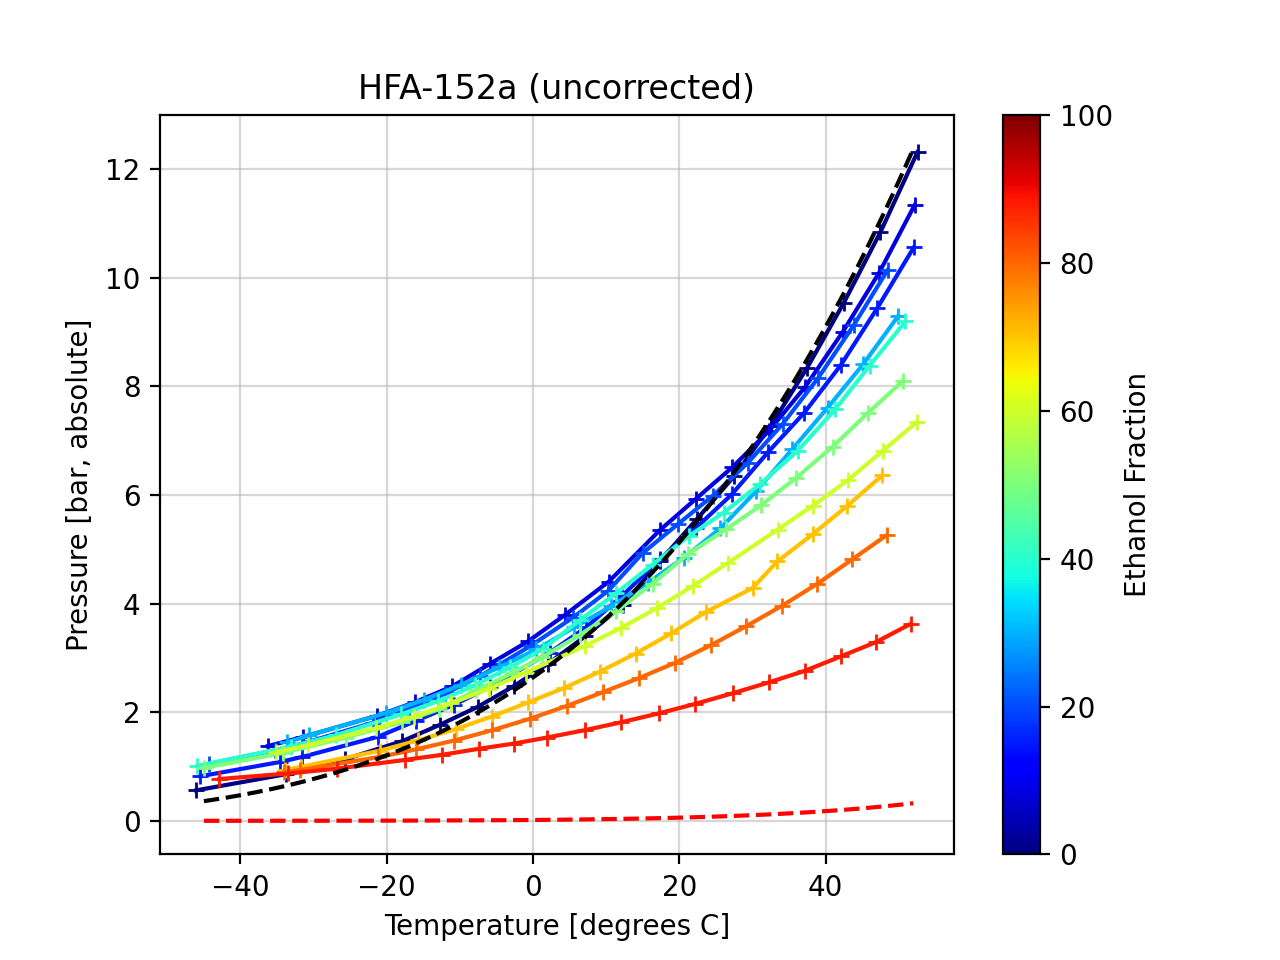

<IPython.core.display.Javascript object>


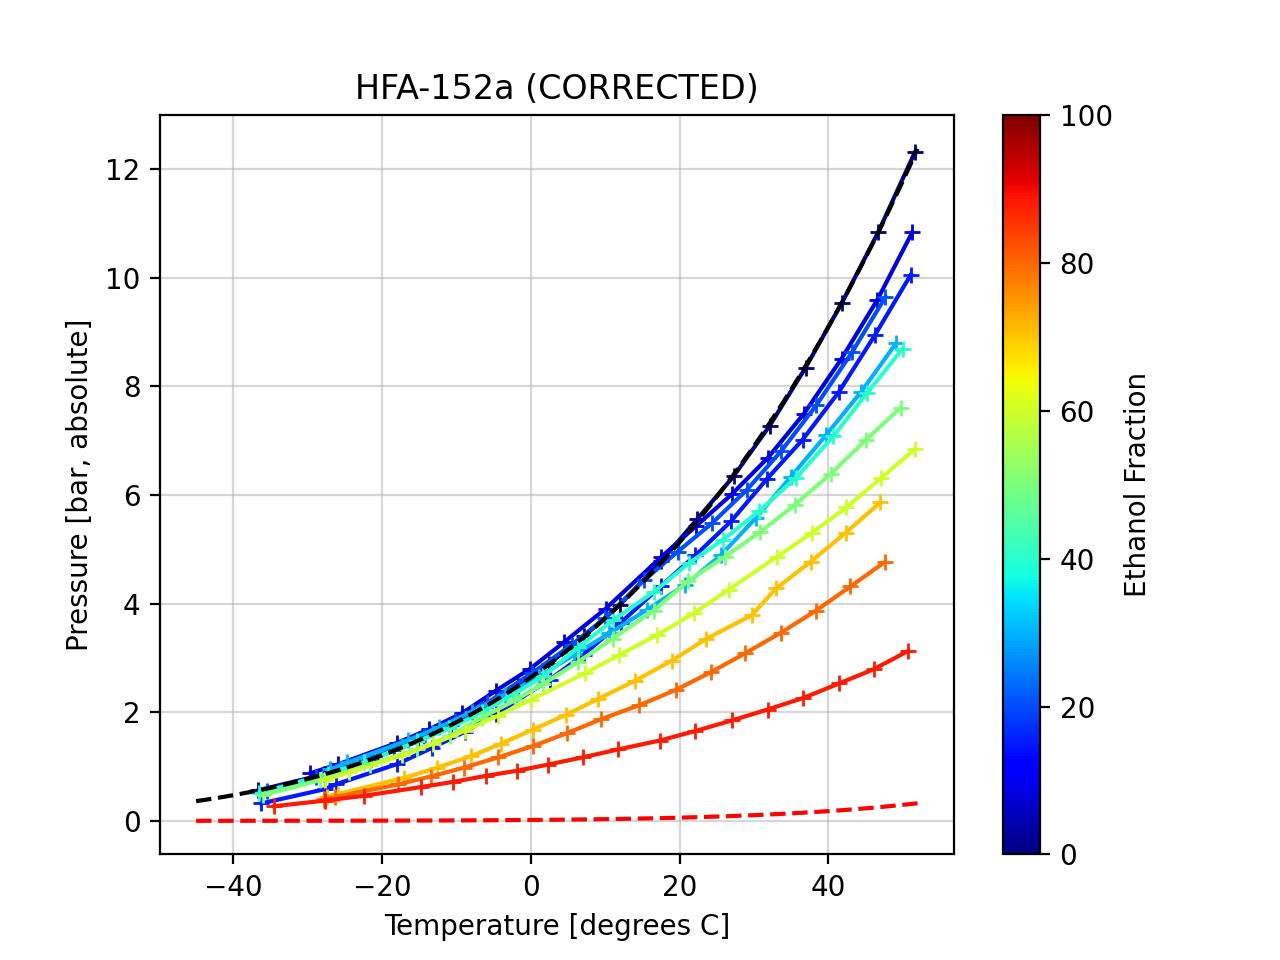

In [73]:
def line_plots(datasets, propellant='',refDataset=None):
    # Set up a colour scheme 
    cmap=plt.cm.jet
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))

    # Make figure uncorrected
    fig=plt.figure();plt.grid(alpha=.5)
    plt.xlabel("Temperature [degrees C]")
    plt.ylabel("Pressure [bar, absolute]")
    plt.title("%s (uncorrected)" % propellant)
    for dataset in datasets:
        plt.plot(dataset['Canister_Tcal_degC'], dataset['Pressure_bar_abs'],marker='+',\
                 c=cmap(dataset['EthanolFraction']/100.), label='%.1f%% Ethanol' % (dataset['EthanolFraction']))
    plt.colorbar(sm,label='Ethanol Fraction',ax=plt.gca());

    if refDataset is not None:
        plt.plot(refDataset['NIST_Temp_degC'], refDataset['Pressure_bar_abs'],\
                 marker=None,ls='--',c='k', label='PURE PROP NIST')
        plt.plot(refDataset['NIST_Temp_degC'], ethanol_antoine(refDataset['NIST_Temp_degC']),\
                marker=None,ls='--',c='r', label='PURE ETHANOL')

    
    # Make figure corrected
    fig=plt.figure();plt.grid(alpha=.5)
    plt.xlabel("Temperature [degrees C]")
    plt.ylabel("Pressure [bar, absolute]")
    plt.title("%s (CORRECTED)" % propellant)
    for dataset in datasets:
        plt.plot(dataset['Canister_Tcal_degC']-dataset['Tcal_correction'],\
                 dataset['Pressure_bar_abs']-dataset['Pressure_correction'],\
                 marker='+',\
                 c=cmap(dataset['EthanolFraction']/100.), label='%.1f%% Ethanol' % (dataset['EthanolFraction']))
        
    if refDataset is not None:
        plt.plot(refDataset['NIST_Temp_degC'], refDataset['Pressure_bar_abs'],\
                 marker=None,ls='--',c='k', label='PURE PROP NIST')
        plt.plot(refDataset['NIST_Temp_degC'], ethanol_antoine(refDataset['NIST_Temp_degC']),\
                marker=None,ls='--',c='r', label='PURE ETHANOL')
        
        
    plt.colorbar(sm,label='Ethanol Fraction',ax=plt.gca());
    
    

line_plots(HFA152a_datasets,"HFA-152a",HFA152a_NIST);

### Make surface plot of pressure

<IPython.core.display.Javascript object>


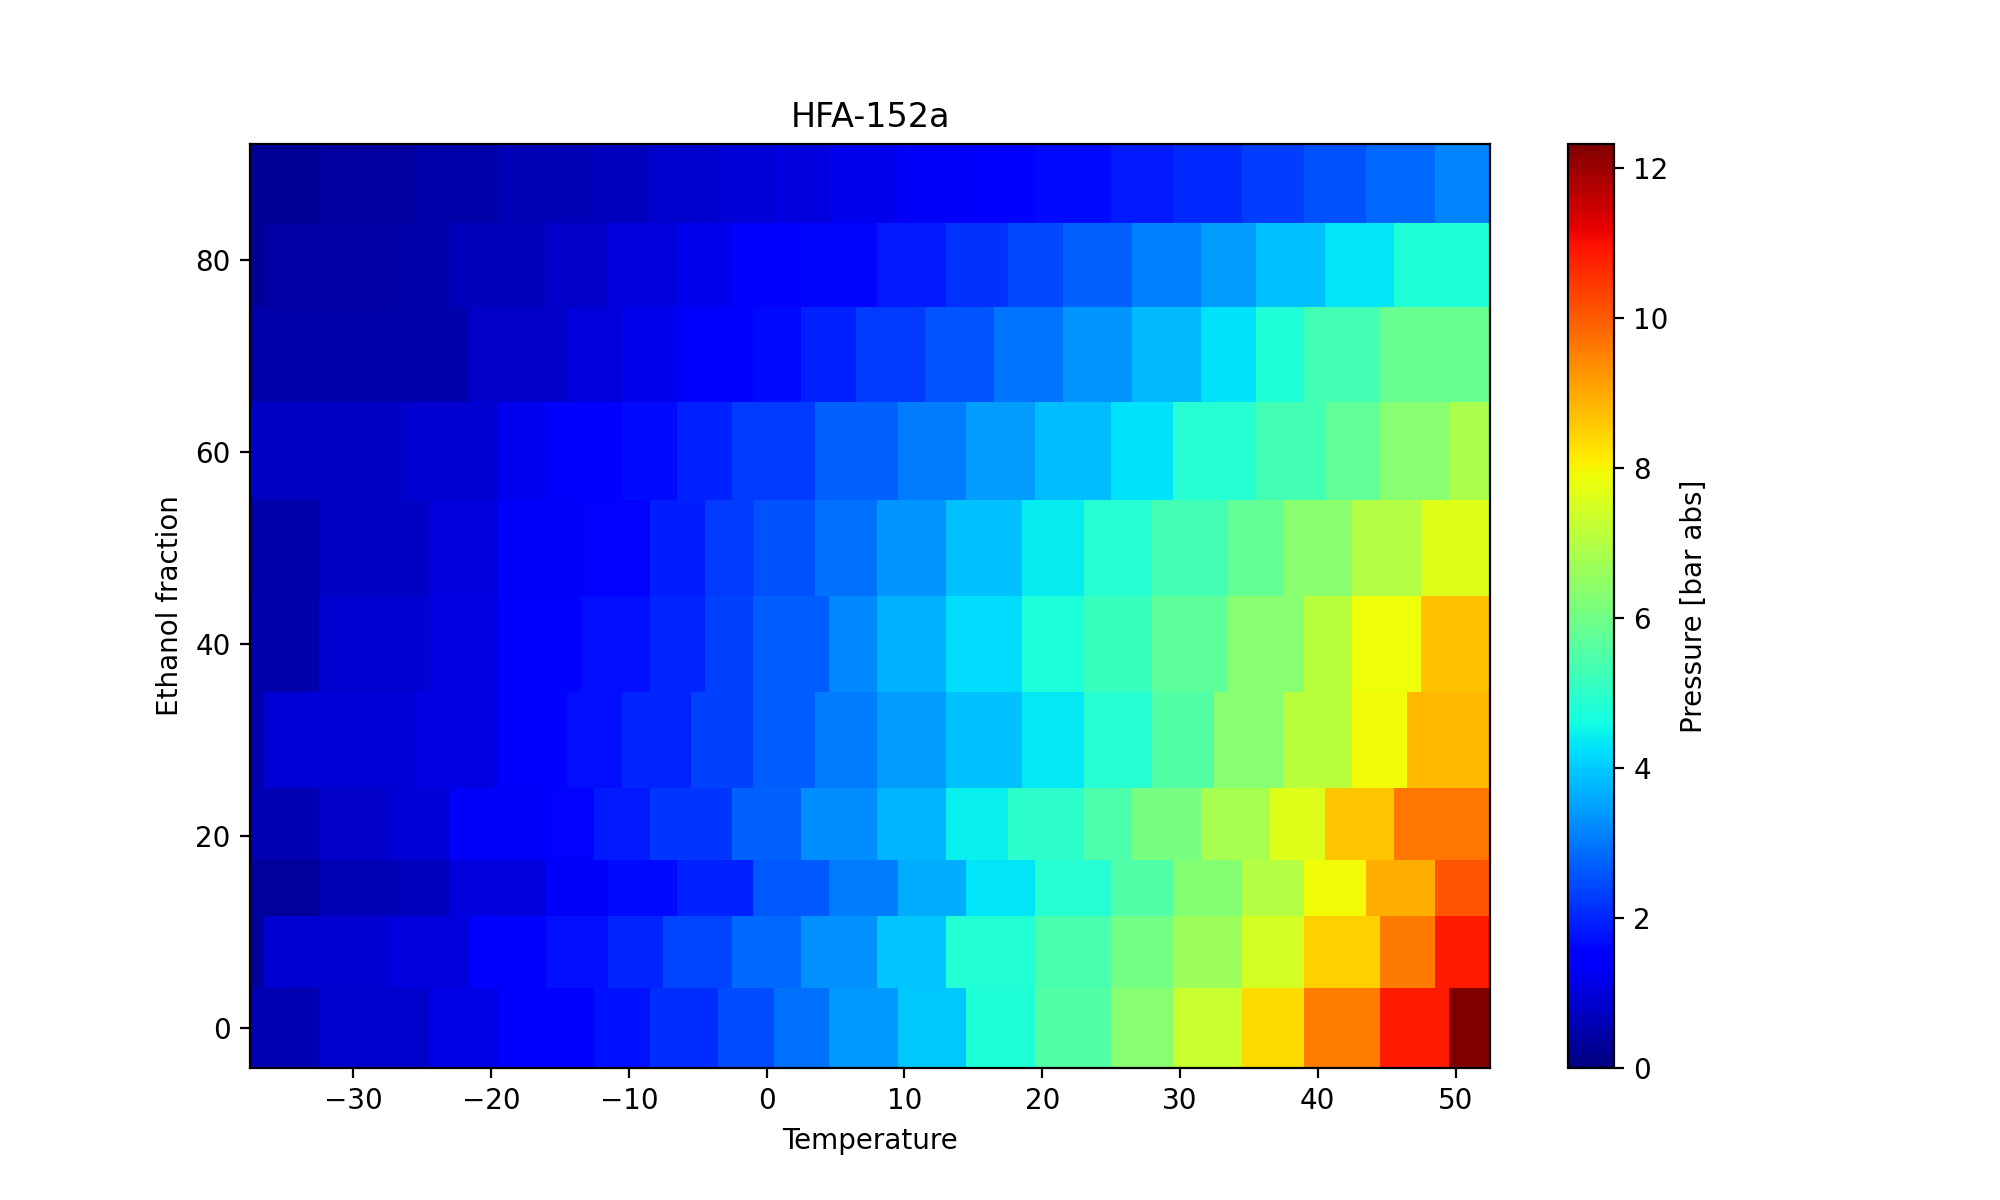

In [74]:
def make_surf(datasets,propellant='',corrected=True):
    
    # Get all data to 1D
    
    if corrected:
        all_P = np.concatenate([ dataset['Pressure_bar_abs']-dataset['Pressure_correction'] for dataset in datasets ])
        all_T = np.concatenate([ dataset['Canister_Tcal_degC']-dataset['Tcal_correction'] for dataset in datasets ])
    else:
        all_P = np.concatenate([ dataset['Pressure_bar_abs'] for dataset in datasets ])
        all_T = np.concatenate([ dataset['Canister_Tcal_degC'] for dataset in datasets ])
    
    all_E = np.concatenate([ dataset['EthanolFraction']*np.ones_like(dataset['Pressure_bar_abs'])  for dataset in datasets ])

    # Make coordinate grid to interpolate onto.
    eth = [ dataset['EthanolFraction'] for dataset in datasets ]
    temp = np.unique(np.round(all_T,0)) # nearest degree C
    tt, ee = np.meshgrid(temp, eth)
    
    # Interpolate using Delaunay triangulation
    L1=scipy.interpolate.NearestNDInterpolator([(all_T[n], all_E[n]) for n in range(len(all_T))], all_P)
    pts = [(tt.ravel()[n], ee.ravel()[n]) for n in np.arange(np.product(ee.shape))]
    Pmap = L1(pts).reshape(ee.shape)

    # Make graph
    fig=plt.figure(figsize=(10,6))
    ph=plt.pcolormesh(tt,ee,Pmap,cmap=plt.cm.jet,vmin=0)
    plt.colorbar(ph,label="Pressure [bar abs]")
    plt.xlabel('Temperature')
    plt.ylabel('Ethanol fraction')
    plt.title(propellant);
    

make_surf(HFA152a_datasets, "HFA-152a");

## 4. Apply correction to HFO-1234ze(E) data

In [75]:
HFO1234ze_E8 = {'EthanolFraction':8, 'CorrectionParameters':(popt2A,HFO1234_E0A['Pressure_Correction_Popt']),\
                'Canister_Tcal_degC':np.array([51.54911539,46.71524091,41.89159722,36.97505834,32.06446305,27.04029865,22.16333639,17.19771846,12.23877575,6.27139338,1.191234772,-5.919150745,-11.02842409,-16.11134997,-21.20153516,-31.40577569,-34.60862698,-45.92022197]),\
                'Pressure_bar_abs':np.array([9.190086994,8.125191935,7.167761719,6.283245867,5.595559583,5.046365249,4.459301077,3.864688275,3.350156456,2.820301846,2.416594651,1.953620348,1.662659978,1.382447503,1.183609183,0.868989486,0.788664867,0.564006698]),\
                'PressureTxTemp_degC':np.array([20.27921314,20.20882646,20.1906614,20.16164975,20.13280782,20.04000965,20.0548005,19.8773453,19.8764391,19.76010915,19.87898552,19.7160188,19.71748735,19.628199,19.58316705,19.79596755,19.79654526,20.08906611])}

HFO1234ze_E30 = {'EthanolFraction':30, 'CorrectionParameters':(popt2G,HFO1234_E0G['Pressure_Correction_Popt']),\
                 'Canister_Tcal_degC':np.array([48.03927923,43.25778777,38.43679542,33.56732733,28.69306303,23.87346035,18.91709223,13.94559588,8.901815215,3.818092233,-1.331582627,-6.480168529,-11.60552466,-16.66330105,-21.64874291,-31.3098184,-33.19850955]),\
                 'Pressure_bar_abs':np.array([8.050724798,7.30767265,6.676566074,6.144365056,5.410216199,4.951320953,4.496189705,4.060396366,3.63249572,3.241242998,2.840927161,2.518969432,2.232375929,1.983356952,1.761006088,1.424487137,1.345964087]),\
                 'PressureTxTemp_degC':np.array([19.82629052,20.0712432,20.50563735,20.83623815,21.48710473,22.16107791,21.91240345,21.38407657,20.65640685,20.30965482,19.85916079,19.81818936,20.23351831,21.34246978,23.98259071,22.44379833,21.41360248])}

HFO1234ze_E40 = {'EthanolFraction':40, 'CorrectionParameters':(popt2G,HFO1234_E0G['Pressure_Correction_Popt']),\
                 'Canister_Tcal_degC':np.array([46.77621003,46.67093847,42.07478715,37.29567802,32.38149239,27.58901288,22.81991423,18.02619638,13.17359431,8.06672455,3.106725095,-1.987913542,-7.039554859,-12.09335115,-17.13680373,-22.2631592,-32.41624461,-34.41803501]),\
                 'Pressure_bar_abs':np.array([7.200751743,7.093858719,6.598644703,6.031137055,5.488893681,5.048366563,4.646471864,4.251860819,3.87708763,3.47888852,3.146091808,2.820077914,2.499927216,2.247774188,2.030520051,1.822941271,1.483634371,1.384430206]),\
                 'PressureTxTemp_degC':np.array([20.87105827,19.68623521,20.63296276,20.37625042,19.7238259,20.47797413,20.67522121,21.11516894,21.40514063,19.82882765,19.40868605,19.46286143,19.58978189,19.31815678,19.37420816,19.44381612,19.52851004,19.3556819])}

HFO1234ze_E50 = {'EthanolFraction':50, 'CorrectionParameters':(popt2G,HFO1234_E0G['Pressure_Correction_Popt']),\
                 'Canister_Tcal_degC':np.array([49.15582093,44.34547539,39.48982752,34.60938298,29.66268742,24.71762496,19.72836055,14.68915704,9.661820433,4.595732717,-0.503239004,-5.68762316,-10.88695387,-16.01949621,-21.24589507,-28.58617522,-34.35174023]),\
                 'Pressure_bar_abs':np.array([7.022254939,6.404162401,5.780270643,5.18178803,4.62150932,4.102373001,3.640796537,3.214756691,2.831833373,2.496736054,2.18892099,1.916133263,1.690332909,1.472876053,1.288561421,1.078339605,0.94068873]),\
                 'PressureTxTemp_degC':np.array([26.98560296,26.79568789,26.47609927,26.39574676,26.29932678,25.94999734,25.71491184,25.60123794,25.49540584,25.57047604,25.30955658,25.35102948,25.26103586,25.17687419,24.98900483,24.70691339,24.10984112])}

HFO1234ze_E60 = {'EthanolFraction':60, 'CorrectionParameters':(popt2G,HFO1234_E0G['Pressure_Correction_Popt']),\
                 'Canister_Tcal_degC':np.array([45.76111156,41.33088502,36.65650743,31.94357171,27.08905517,22.16460178,17.53220596,12.63376261,7.817155521,3.127219151,-1.495344182,-6.208802557,-11.38113183,-16.15328331,-21.08661403]),\
                 'Pressure_bar_abs':np.array([6.360645593,5.796877179,5.238557715,4.71477174,4.222336717,3.761228988,3.355285667,2.977514028,2.6369674,2.334505091,2.059976315,1.815087111,1.59394983,1.413232919,1.250508927]),\
                 'PressureTxTemp_degC':np.array([25.10374065,24.89842331,24.69125259,24.49702037,24.22712125,22.37685826,22.15483162,21.89508912,22.12314746,22.48265186,22.7924496,23.23359249,24.57040751,25.45745189,26.53856236])}

HFO1234ze_E70 = {'EthanolFraction':70, 'CorrectionParameters':(popt2G,HFO1234_E0G['Pressure_Correction_Popt']),\
                 'Canister_Tcal_degC':np.array([48.87532409,44.04789682,39.21033691,34.32739478,29.43948419,24.5001058,19.54466231,14.57437837,9.527114383,4.590227935,-0.305339782,-5.839016181,-10.99605942,-15.54253743,-21.50641815,-31.8960596,-34.83896371]),\
                 'Pressure_bar_abs':np.array([5.108935126,4.646845985,4.212087634,3.805032451,3.428573609,3.076251495,2.757115423,2.464416301,2.188953591,1.952030744,1.738068234,1.53026003,1.355104327,1.222719612,1.073692625,0.870460806,0.822513887]),\
                 'PressureTxTemp_degC':np.array([23.74881668,23.64718079,23.59132662,23.52320582,23.50376142,23.55032212,23.57373577,23.57534309,23.5986246,23.5768252,23.51712329,23.5500258,23.54494493,23.04608719,23.03013251,23.40911664,23.92139301])}


HFO1234ze_E80 = {'EthanolFraction':80, 'CorrectionParameters':(popt2A,HFO1234_E0A['Pressure_Correction_Popt']),\
                 'Canister_Tcal_degC':np.array([50.95741797,46.15901881,41.23915778,36.36799135,31.35940688,26.53656379,21.43434583,16.51860972,11.56194222,6.350207717,1.21430639,-3.448631642,-8.530779299,-13.45224443,-18.39295064,-27.1500045,-34.49948295,-44.04645941]),\
                 'Pressure_bar_abs':np.array([3.571220576,3.343226869,3.071381216,2.732577389,2.535283468,2.325027167,2.134377337,1.968040748,1.815000516,1.685710145,1.548495491,1.440445868,1.331185455,1.240750128,1.161546315,1.033487411,0.946476688,0.850798259]),\
                 'PressureTxTemp_degC':np.array([18.54692812,19.19029218,19.49483511,19.42965125,19.42419517,19.3849772,19.12034126,19.336203,19.48381115,19.51256672,19.42239983,19.92290266,20.23830998,19.47025507,19.67786938,19.98552246,20.03075158,20.0048817])}

HFO1234ze_E90 = {'EthanolFraction':90, 'CorrectionParameters':(popt2A,HFO1234_E0A['Pressure_Correction_Popt']),\
                 'Canister_Tcal_degC':np.array([52.33328385,47.37806698,42.4872981,37.57803171,32.61261566,27.65789364,22.53522848,17.5887927,12.36343072,7.29713854,2.139615204,-2.398182565,-7.777381165,-12.65817957,-17.72784147,-27.63418758,-34.5246928,-46.01880165]),\
                 'Pressure_bar_abs':np.array([2.436422105,2.233205436,2.041765438,1.848778988,1.696867467,1.563054065,1.441316126,1.333219734,1.223891759,1.123077884,1.040586887,0.960477627,0.893038843,0.81129259,0.74201126,0.636023776,0.585173132,0.513836831]),\
                 'PressureTxTemp_degC':np.array([19.53919384,18.47087621,19.39007205,19.55548136,19.40630532,19.42694609,19.53505308,19.62988968,19.16325308,19.15107421,19.1806218,19.28370998,19.37384759,19.3546604,19.28591847,19.42752413,19.38509517,19.58167604])}

### Make corrections for HFO-1234ze

In [103]:
# Put these in manually:
HFO1234_E0A['CorrectionParameters'] = (popt2A,HFO1234_E0A['Pressure_Correction_Popt'])
HFO1234_E0G['CorrectionParameters'] = (popt2G,HFO1234_E0G['Pressure_Correction_Popt'])

HFO1234ze_datasets = (HFO1234_E0A, HFO1234ze_E8, HFO1234ze_E30, HFO1234ze_E40, HFO1234ze_E50, HFO1234ze_E60,\
                      HFO1234ze_E70, HFO1234ze_E80, HFO1234ze_E90 )

# Loop all data sets, and apply correction & save it.
for dataset in HFO1234ze_datasets:
    
    # Temperature correction
    Tdiff = dataset['Canister_Tcal_degC']-dataset['PressureTxTemp_degC']
    dataset['Tcal_correction'] = temperatureCorrectionFunction(Tdiff, *dataset['CorrectionParameters'][0])
    #dataset['Tcal_correction'] = temperatureCorrectionFunction(Tdiff, *popt2A)
    
    # Pressure correction
    if dataset['CorrectionParameters'][1] is not None:
        dataset['Pressure_correction'] = pressureCorrectionFunction(dataset['Canister_Tcal_degC'] ,\
                                                 *dataset['CorrectionParameters'][1])
    else:
        dataset['Pressure_correction'] = np.zeros_like(dataset['Canister_Tcal_degC'])
    
    if dataset['EthanolFraction']>0: dataset['Pressure_correction'] += 0.5
    

Plot results

<IPython.core.display.Javascript object>


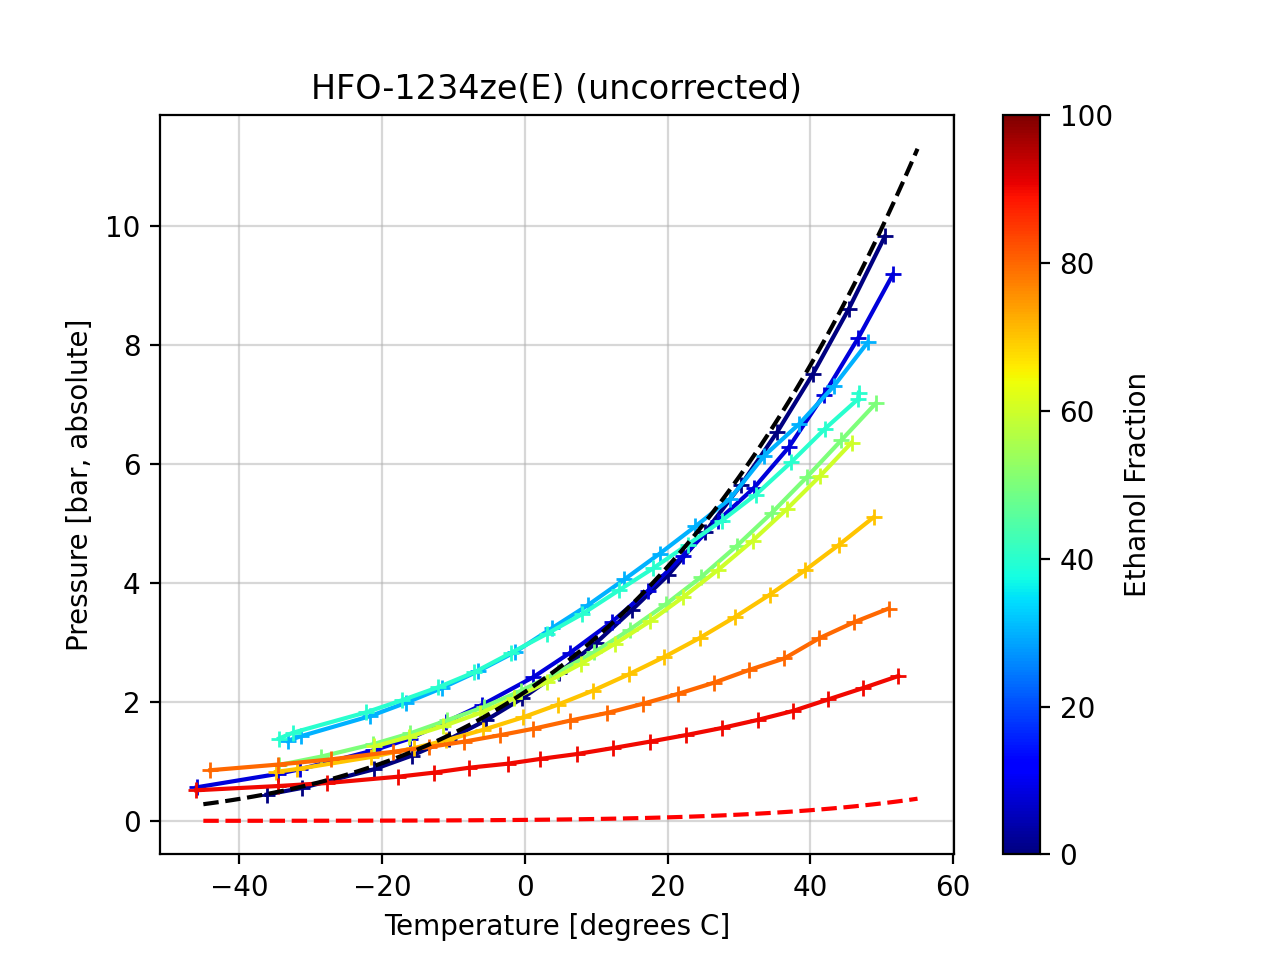

<IPython.core.display.Javascript object>


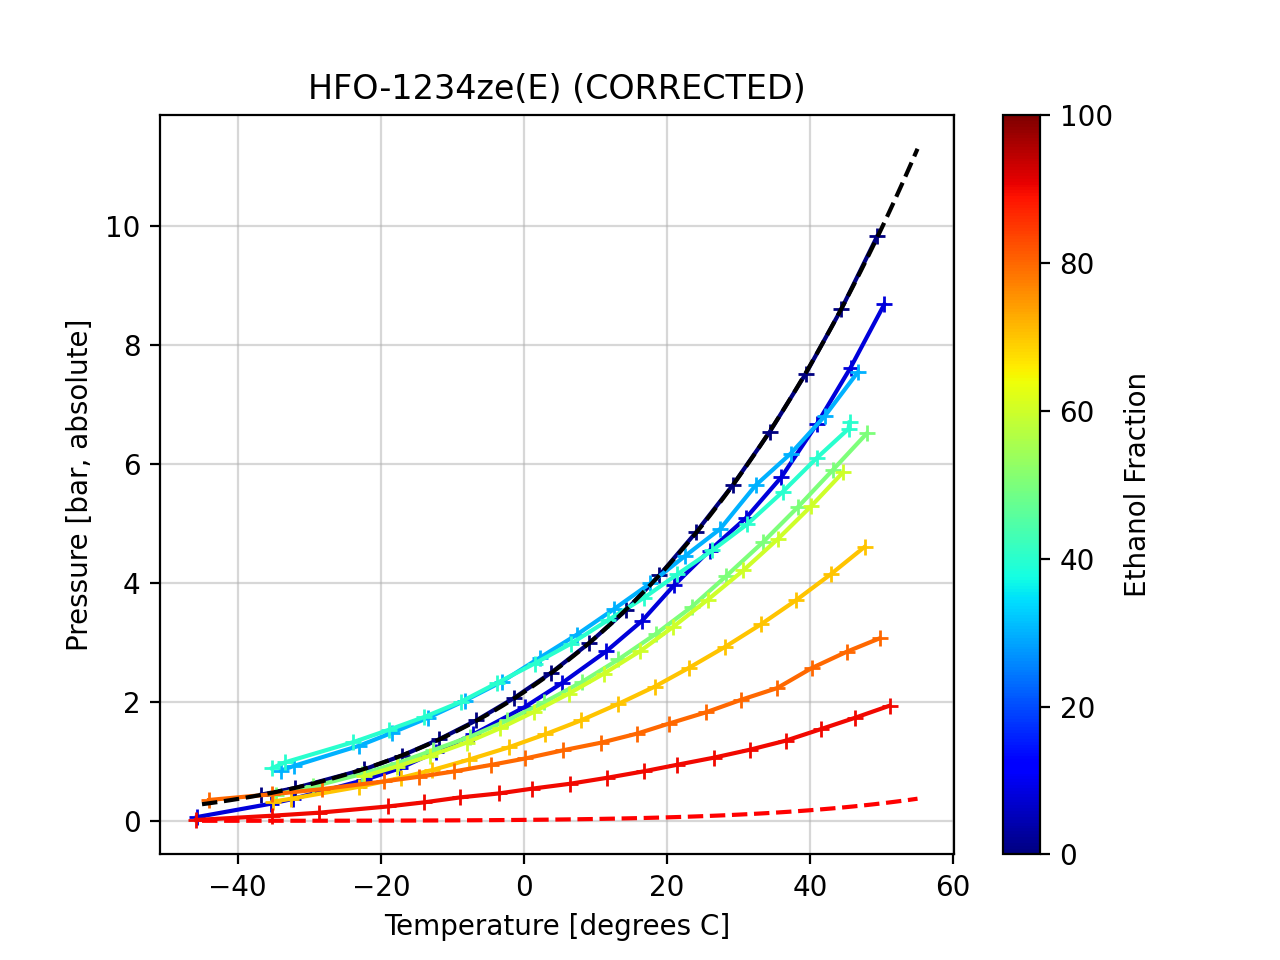

<IPython.core.display.Javascript object>


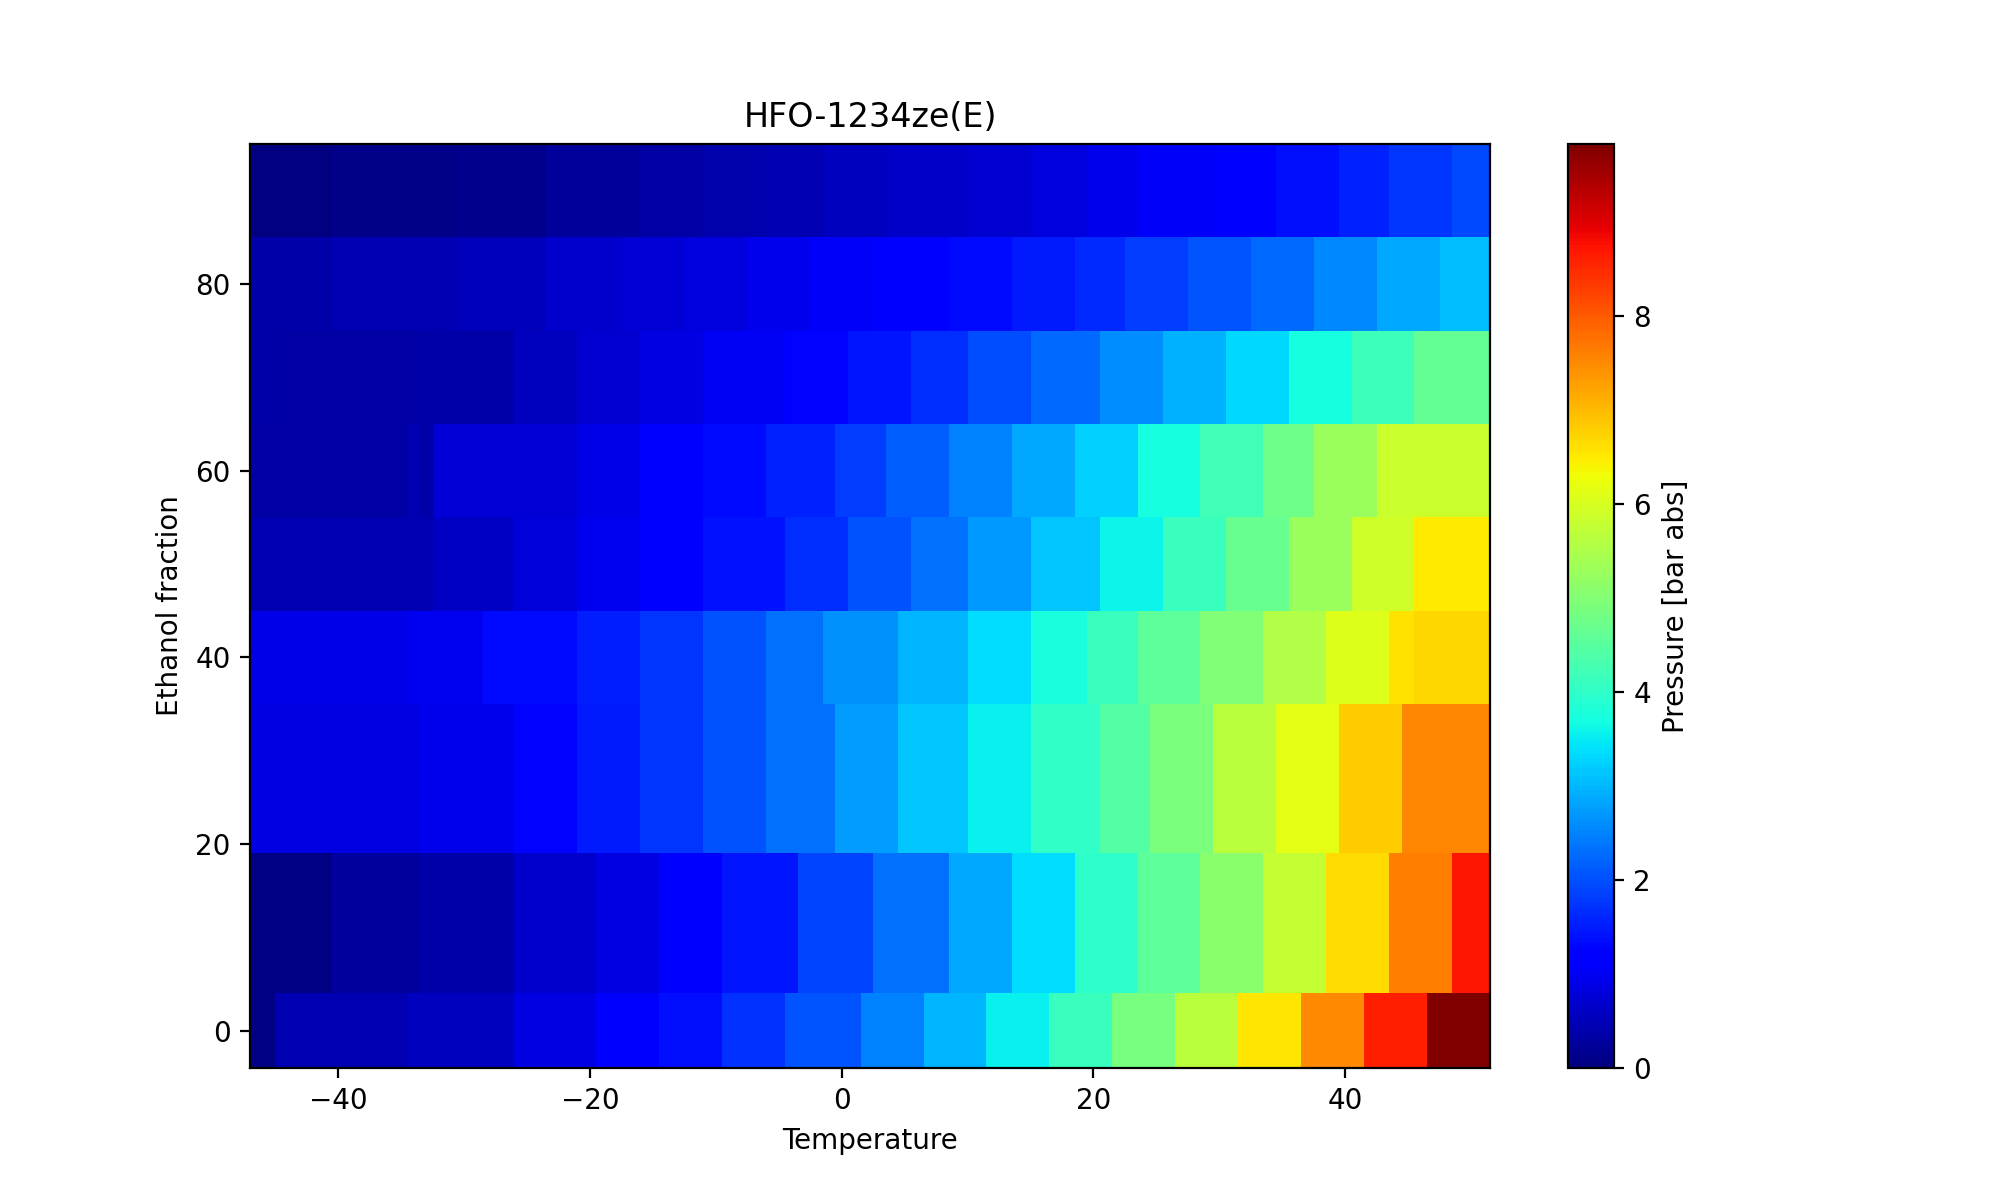

In [104]:
line_plots(HFO1234ze_datasets, "HFO-1234ze(E)", HFO1234_NIST)
make_surf(HFO1234ze_datasets, "HFO-1234ze(E)")

## 5. Apply correction HFA-134a data 

In [80]:
# From Swetha: R134a_Data.xlsx

HFA134a_E8 = {'EthanolFraction':8, 'CorrectionParameters':(popt3A,HFA134a_E0A['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([50.9889057903494,45.9761625291181,40.8575274875208,35.8510891166667,30.7198304159734,25.6613454575707,15.6760434276206,10.7616858402662,5.80591839434276,0.800916083394342,-4.28890252911815,-9.33507799500831,-14.2821383860233,-19.2961717138103,-29.4885752246256,-34.727016921797]),\
              'Pressure_bar_abs':np.array([11.8502296131331,10.5551374288992,9.41125082328135,8.38394854354977,7.5211371174954,6.80848106788389,5.54664875099535,4.88097316254233,4.2960778255188,3.77594393211629,3.3246891054115,2.90800986816337,2.55355408257954,2.19149552212666,1.71656607824856,1.52291316364302]),\
              'PressureTxTemp_degC':np.array([20.7958833610649,20.7884369384359,20.7861474209649,20.7824219633943,20.8187189683862,20.8368544093178,20.8666271214643,20.9600941763728,20.7477617304492,20.6079875207988,20.6181031613978,20.643541763727,20.8558261231281,21.0121933444255,20.776217470882,20.9348976705491])}

HFA134a_E15 = {'EthanolFraction':15, 'CorrectionParameters':(popt3A,HFA134a_E0A['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([53.1746445652175,47.9937728380635,43.0560498998331,38.0040031218698,27.8815558862876,22.8293792320534,17.7764939297659,12.5616662646566,7.41774058263775,2.25800620568562,-2.12782104340568,-7.61253291122278,-12.5564595294117,-17.7274950644567,-25.2998589778535,-36.0056740734558,-45.0763882051281]),\
              'Pressure_bar_abs':np.array([10.3739951979175,9.25345521877207,8.25444537933114,7.31179945124622,6.2534616296985,5.75012711520108,5.02161275267805,4.30327938777234,3.71977427333406,3.16460763960481,2.68181232516561,2.27722330220604,1.94061808635202,1.65242397111376,1.32213712632041,0.940806620056927,0.700989116085407]),\
              'PressureTxTemp_degC':np.array([18.260064891847,19.0893178036606,19.3266955074875,19.3564991680533,19.7813893510815,19.8164059900167,19.920224625624,20.0639866888519,19.9773610648918,19.8691081530782,20.00721797005,20.1011830282862,19.9514242928452,19.9467820299501,19.9615906821963,19.9022928452579,19.8827021630616])}

HFA134a_E20 = {'EthanolFraction':20, 'CorrectionParameters':(popt3A,HFA134a_E0A['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([53.3727779899497,48.5093733277591,43.2481826086956,37.9996484833334,33.1397636287625,28.1319719031719,22.9638470736434,17.8756906994818,12.681323729097,7.52296994295301,2.33436195819398,-2.39926169972452,-7.54673945652175,-12.8458577926422,-18.1544826588629,-27.5814768561872,-35.178876460768]),\
              'Pressure_bar_abs':np.array([10.0553481355455,9.32237090454079,8.40115807545821,7.56223234343451,6.89021907494038,6.24836757347769,5.67163474408234,5.18647044780669,4.50315302826322,3.95071595773163,3.44706322858712,3.02942895680896,2.58220345808865,2.23941877260766,1.96377657854242,1.56408908635161,1.29495218255886]),\
              'PressureTxTemp_degC':np.array([20.2970349417638,20.1585382695501,20.2240044925122,20.4108161397673,20.6790133111479,20.5016600665558,19.9246843594009,19.7884131447586,19.8537018302831,20.0530840266222,20.0207878535773,20.0029254575709,19.8688660565725,20.0131289517472,20.005179866888,19.381990515807,19.9074599001663])}

HFA134a_E30 = {'EthanolFraction':30, 'CorrectionParameters':(popt3A,HFA134a_E0A['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([51.0914386356073,46.1343955906822,41.1914664833333,36.1069357237937,31.0969751166667,26.142961031614,20.8645275873544,15.9154224292845,10.7281595174709,5.73157650249584,0.62696321530782,-4.68205024625623,-9.82020196672214,-15.0728895507487,-20.324158985025,-30.8636358236273,-34.2792662063228]),\
              'Pressure_bar_abs':np.array([8.84989201402931,8.51906744043532,7.90780191774787,7.31712590424539,6.58314578767945,5.93617169686681,5.27681069667016,4.62878029690988,4.02486188558654,3.49894417117411,3.03099277440862,2.61545326329284,2.19886807236627,1.88135030727733,1.61786610219712,1.19627294412148,1.06780204968116]),\
              'PressureTxTemp_degC':np.array([20.9808472545757,20.9422777038271,20.8770289517473,20.9695164725461,20.8206188019966,20.6499123128121,20.4965655574042,20.4994402662229,20.7675693843594,20.8440256239602,20.7704549084858,20.6527289517473,20.727577204659,20.657399001664,20.5420425956738,20.9965570715474,20.6846420965057])}

HFA134a_E40 = {'EthanolFraction':40, 'CorrectionParameters':(popt3A,HFA134a_E0A['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([53.4862785460992,48.6548137855946,43.54481484375,38.6284393446603,33.5403065661641,28.5317904865772,23.4037987123746,18.3699461231281,13.2290489473684,8.12005055518393,2.89727823825502,-1.71947840166667,-6.71397823913044,-11.9441427090301,-16.8793968729097]),\
              'Pressure_bar_abs':np.array([8.20671968446001,7.94787059771856,7.45245858211532,6.87686120821091,6.35848041311582,5.9149568135139,5.53510448605254,4.91115991631411,4.19098458657549,3.65118818094865,3.16660612571495,2.79450368843909,2.44879965076561,2.10925483363922,1.85189308894255]),\
              'PressureTxTemp_degC':np.array([19.613915141431,19.8352063227953,20.0118835274543,19.92584359401,19.7195341098169,19.6281730449251,19.8633394342762,19.9701181364393,19.959459234609,20.0938086522462,19.7714725457571,20.0286655574043,20.0428569051581,20.2506139767055,20.8024342762063])}

HFA134a_E50 = {'EthanolFraction':50, 'CorrectionParameters':(popt3G,HFA134a_E0G['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([47.9793148000001,43.2016629284526,38.3192779534109,33.4864174542429,28.5804572379368,23.7408983194675,18.8039653078203,13.8769650666667,8.86958199667221,3.86878865391015,-1.21220638918469,-6.31172858236273,-11.4944602828619,-16.6279036439268,-21.7680568053245,-32.4307157237937,-35.4669238768718]),\
              'Pressure_bar_abs':np.array([7.03380889653655,6.6714914988695,6.3295332925426,5.98104572844585,5.3799096174265,4.84029492548421,4.42509513974422,4.00866650562688,3.62433503384125,3.24761889766094,2.89744237335244,2.56248291408347,2.273696038894,2.00860347051655,1.77132946368611,1.3833951217107,1.27352913282885]),\
              'PressureTxTemp_degC':np.array([20.6751930116471,20.628060399335,20.5366956738768,20.5825878535775,20.5522502495839,20.5852846921798,20.5892653910152,20.6366098169715,20.5224083194675,20.395084568004,20.360131780366,20.3920895174709,20.3951874167776,20.3960697171381,20.3721068219635,20.3494292845261,20.2714288330282])}

HFA134a_E60 = {'EthanolFraction':60, 'CorrectionParameters':(popt3G,HFA134a_E0G['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([47.6236220133112,42.945885124792,38.0674579034942,33.3551182833333,28.5393830615641,23.793635906822,18.8675090848586,14.1320098003328,9.22934367166666,4.2522221297837,-0.790649921297837,-5.86637856073212,-11.0262360232945,-16.0945642096506,-21.4720357404326,-32.1377085357736,-35.6602888851913]),\
              'Pressure_bar_abs':np.array([6.22840050051427,5.94433349048061,5.64945337694161,5.18566849928496,4.80097430002717,4.36623822427075,3.92966675548407,3.53321870727884,3.15921456636566,2.80198522654689,2.47839889089425,2.18171416804324,1.92182868870474,1.67052043398504,1.46588366944711,1.12638160466391,1.03187566371333]),\
              'PressureTxTemp_degC':np.array([20.5540366056573,20.7372071547416,20.7319768718796,20.8261572379368,20.8589981697173,21.2299499168052,21.9539424292847,22.5601672263265,22.9783722129783,23.2104262895176,23.3150547420967,23.1780617304491,22.6484247920134,21.8605148086523,23.110077204659,23.3628582362727,21.0062049275846])}

HFA134a_E70 = {'EthanolFraction':70, 'CorrectionParameters':(popt3G,HFA134a_E0G['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([49.1979624292846,44.3326721963394,39.4404954242928,34.5380461564059,29.6027219134775,24.6835099500832,19.7202371048253,14.7675894009984,9.95660624000001,4.92091865776294,-0.1922699369,-5.32269056905158,-10.5019126333333,-15.6915637271215,-20.938276655574,-30.6157581530782,-33.3260033610648]),\
              'Pressure_bar_abs':np.array([6.46635745289491,5.92816798375869,5.33171135395812,4.79820501620898,4.3092195397014,3.86072478754746,3.44043492267915,3.05031608072707,2.70475994953378,2.38186341256149,2.06589556785155,1.79542814460109,1.55422357600527,1.34689692926016,1.16945438867585,1.10494745024678,1.02735779320413]),\
              'PressureTxTemp_degC':np.array([25.8859316552757,25.9016578903515,25.9905614590273,26.0998498833728,26.1037892361692,26.1301449758375,26.1717344114703,26.2311180984153,25.9833272787868,25.9610241989317,26.0326368640535,26.0163129172231,25.9568717521651,25.878733110926,25.4691643356643,25.3056249791287,25.2006638304973])}

HFA134a_E80 = {'EthanolFraction':80, 'CorrectionParameters':(popt3G,HFA134a_E0G['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([49.039005906822,44.1038154908486,39.1825496672213,34.1882321630616,29.3200359900167,24.4478876539102,19.5261951913478,14.4508173211314,9.413217202995,4.35107767221298,-0.740743378369384,-6.02780574043261,-11.2948514833333,-16.5729188519135,-21.8316438103162,-31.3925129118136,-35.4099986855241]),\
              'Pressure_bar_abs':np.array([4.28448827716226,3.9847686603513,3.67117666919218,3.42055682444498,3.159659455599,2.92780073444852,2.69976533364355,2.48467688749619,2.2734867259665,2.07704612986765,1.88959241473646,1.71916327010978,1.55165877177156,1.41228015798473,1.27414899790705,1.09455500707871,1.00436832383486]),\
              'PressureTxTemp_degC':np.array([23.8945216306157,22.6051407653912,21.2456367720466,21.4318702163065,21.5664490339775,22.351483405967,23.110179034942,23.7776334442593,24.2115005828477,24.4175475754043,24.4076715571858,24.0664207986689,22.7866965207259,21.5803575615476,21.4502619206401,22.1880872315633,24.9513928452579])}

HFA134a_E90 = {'EthanolFraction':90, 'CorrectionParameters':(popt3A,HFA134a_E0A['Pressure_Correction_Popt']),\
              'Canister_Tcal_degC':np.array([50.93963685,45.8517861333333,40.7781547587354,35.7849529950083,30.6560035773711,25.7180941763727,20.68860945,15.6023699666667,10.4491584026623,5.35459689517471,0.147140622222463,-5.01295114808652,-10.0945230183333,-13.71352359401,-20.4480331780366,-30.5242914309484,-35.4107023960066]),\
              'Pressure_bar_abs':np.array([2.96331715604671,2.74383126296665,2.52773740857257,2.31412766798665,2.13558165722334,1.97484515007472,1.81955665965633,1.67794654711264,1.5456710929104,1.42900774979095,1.29232781011734,1.18912085012471,1.09749650890262,1.03228993608831,0.939587494518871,0.809111726822085,0.741141602286995]),\
              'PressureTxTemp_degC':np.array([20.9160758735439,20.891751081531,20.7345705490845,20.7187607321136,20.705831780366,21.0819066555743,21.3482474209648,21.2710291181365,20.8227868552413,20.8336374376036,21.0065886855239,21.0241878535775,22.0605407653911,22.9552391014976,23.5000868552413,23.1210302828618,21.1226299500831])}

### Make corrections for HFA-134a

In [85]:
# Put these in manually:
HFA134a_E0A['CorrectionParameters'] = (popt3A,HFA134a_E0A['Pressure_Correction_Popt'])
HFA134a_E0G['CorrectionParameters'] = (popt3G,HFA134a_E0G['Pressure_Correction_Popt'])

HFA134a_datasets = (HFA134a_E0A, HFA134a_E8, HFA134a_E15, HFA134a_E20, HFA134a_E30, HFA134a_E40, HFA134a_E50, HFA134a_E60, HFA134a_E70, HFA134a_E80, HFA134a_E90)

# Loop all data sets, and apply correction & save it.
for dataset in HFA134a_datasets:
    
    # Temperature correction
    Tdiff = dataset['Canister_Tcal_degC']-dataset['PressureTxTemp_degC']
    #dataset['Tcal_correction'] = temperatureCorrectionFunction(Tdiff, *dataset['CorrectionParameters'][0])
    dataset['Tcal_correction'] = temperatureCorrectionFunction(Tdiff, *popt3A)
    
    # Pressure correction
    if dataset['CorrectionParameters'][1] is not None:
        dataset['Pressure_correction'] = pressureCorrectionFunction(dataset['Canister_Tcal_degC'] ,\
                                                 *dataset['CorrectionParameters'][1])
    else:
        dataset['Pressure_correction'] = np.zeros_like(dataset['Canister_Tcal_degC'])
        
    if dataset['EthanolFraction']>0: dataset['Pressure_correction'] += 0.5

Plot results

<IPython.core.display.Javascript object>


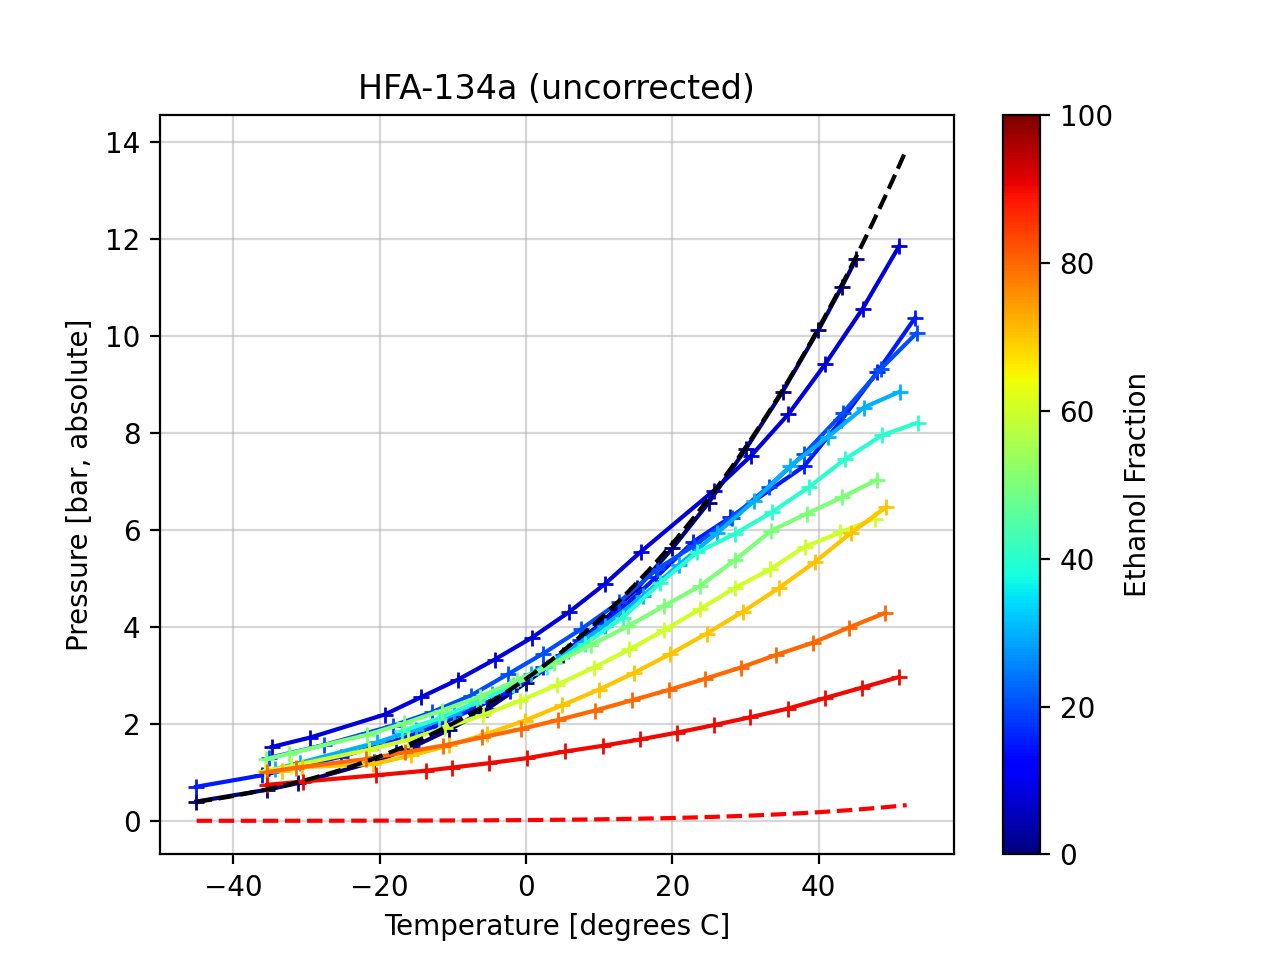

<IPython.core.display.Javascript object>


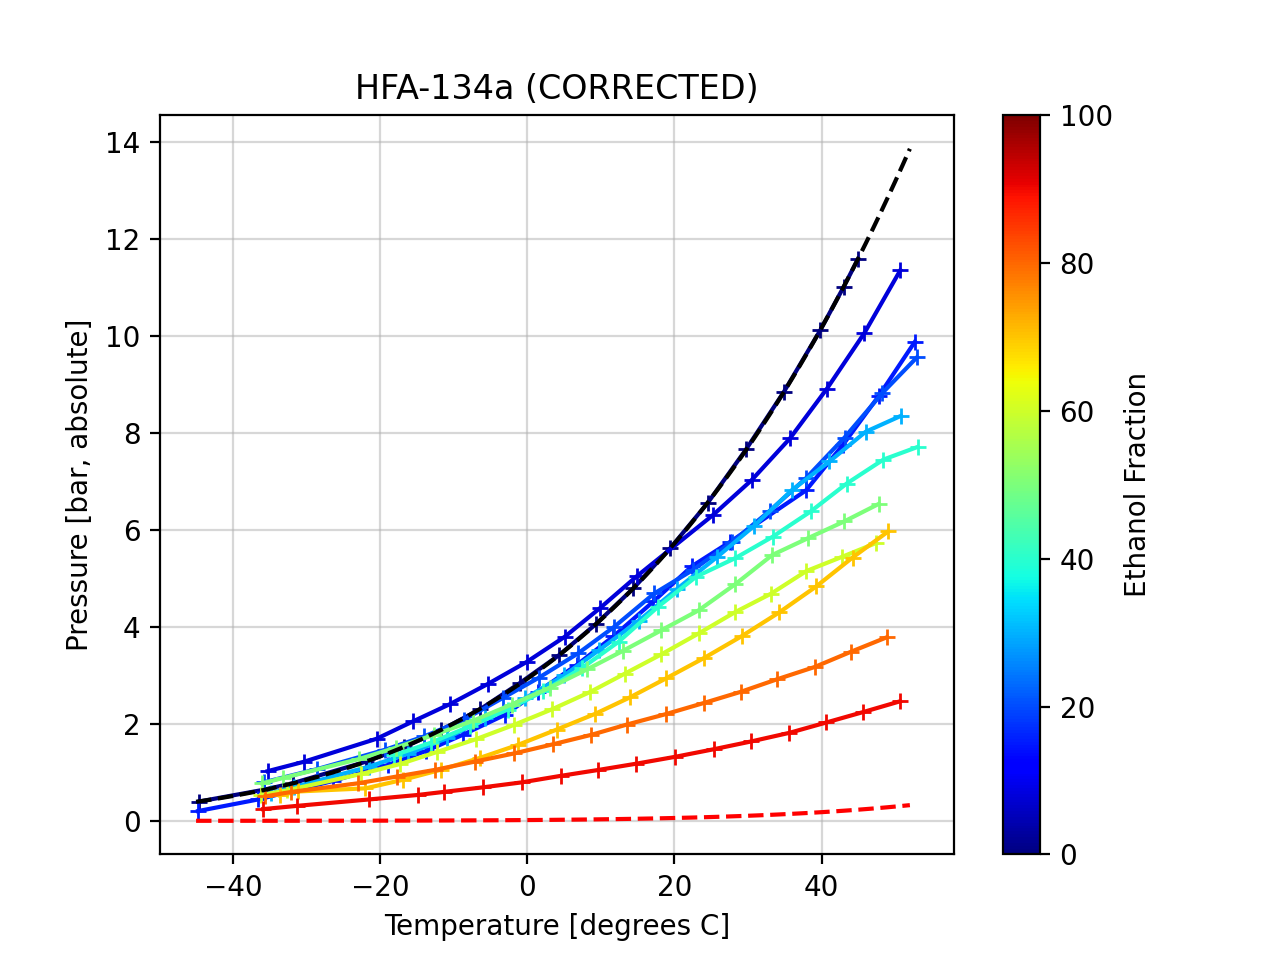

<IPython.core.display.Javascript object>


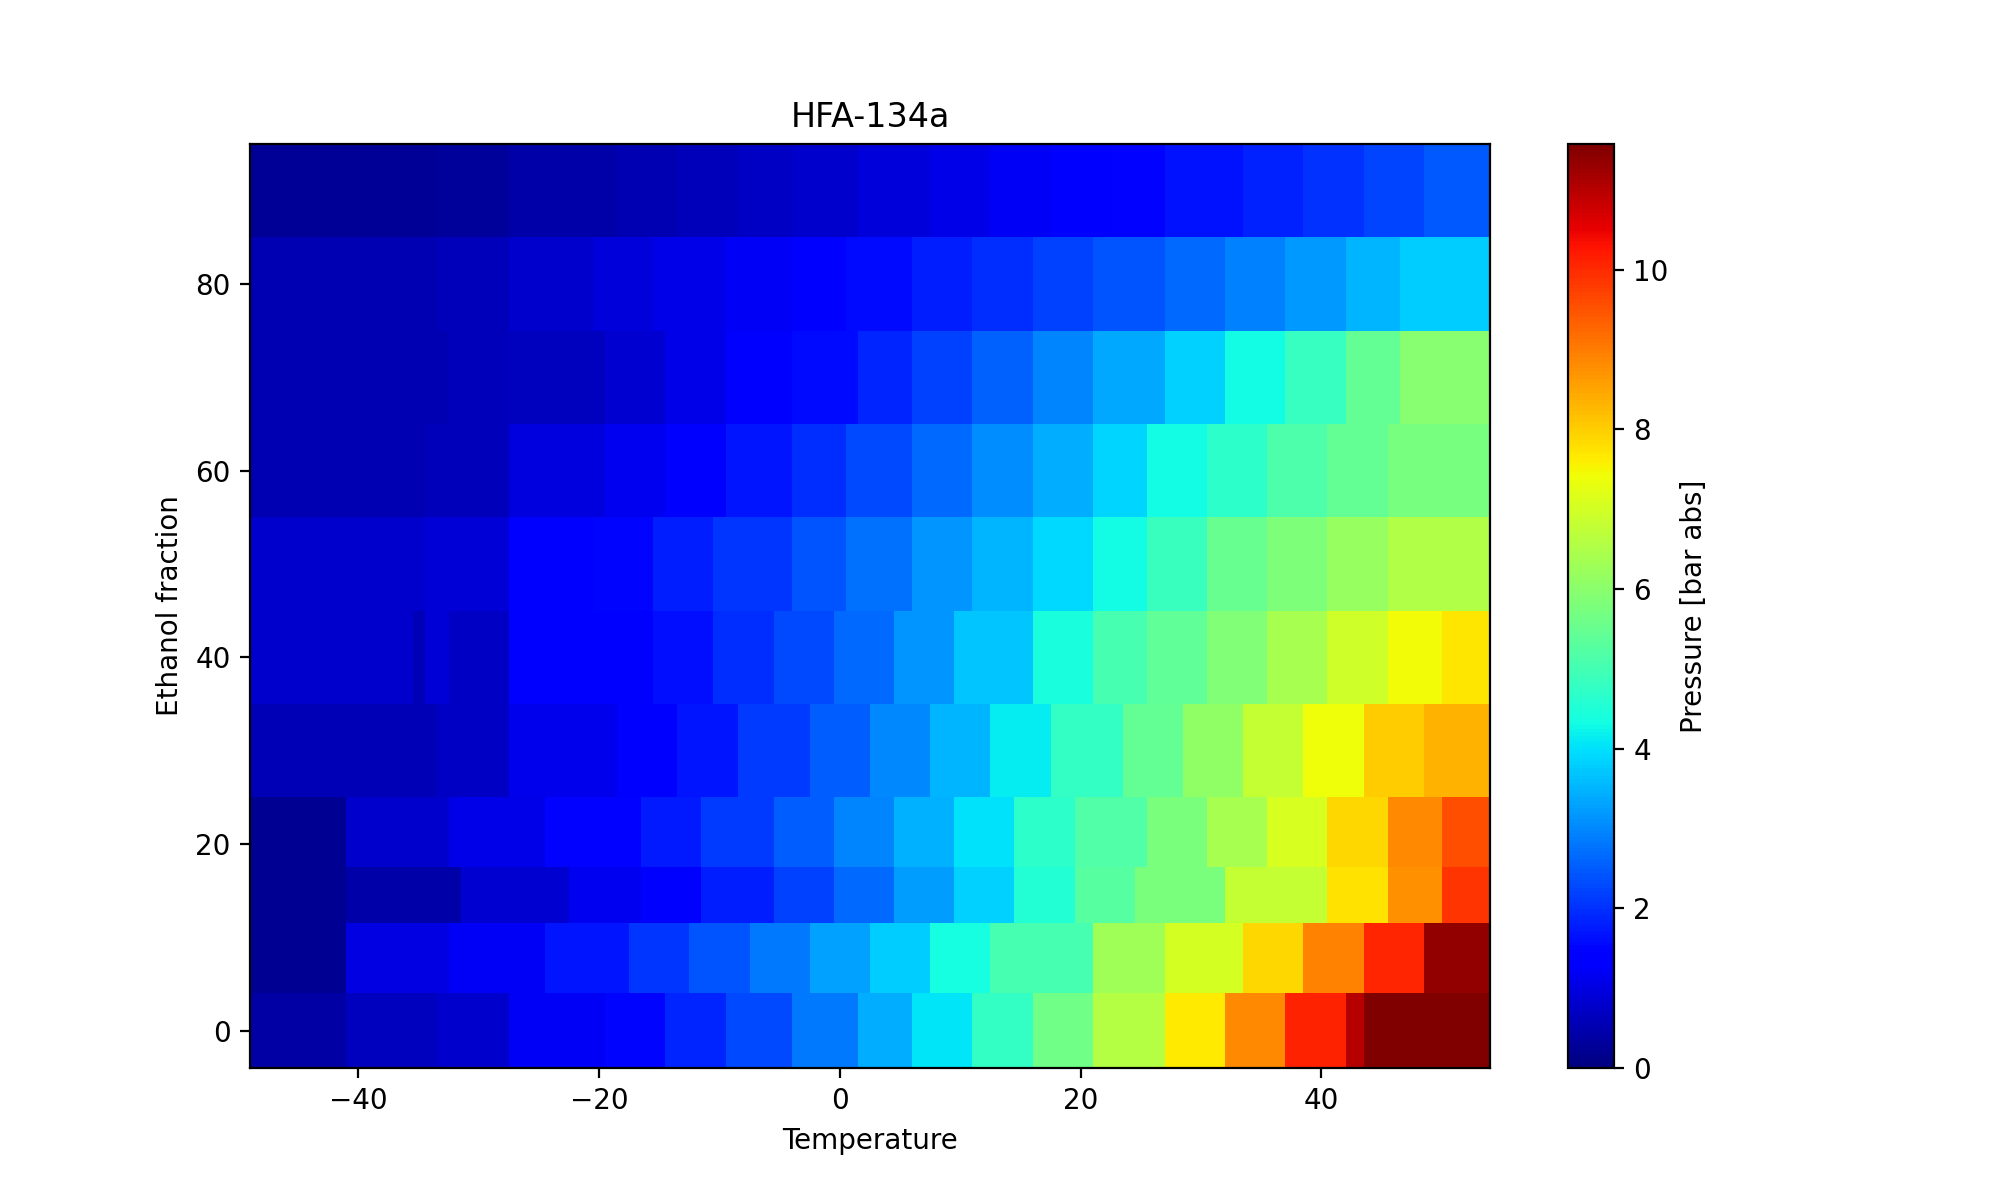

In [86]:
line_plots(HFA134a_datasets,"HFA-134a", HFA134a_NIST);
make_surf(HFA134a_datasets,"HFA-134a");

## 6. Production-ready plots 
For RDD 2023 paper.

<IPython.core.display.Javascript object>


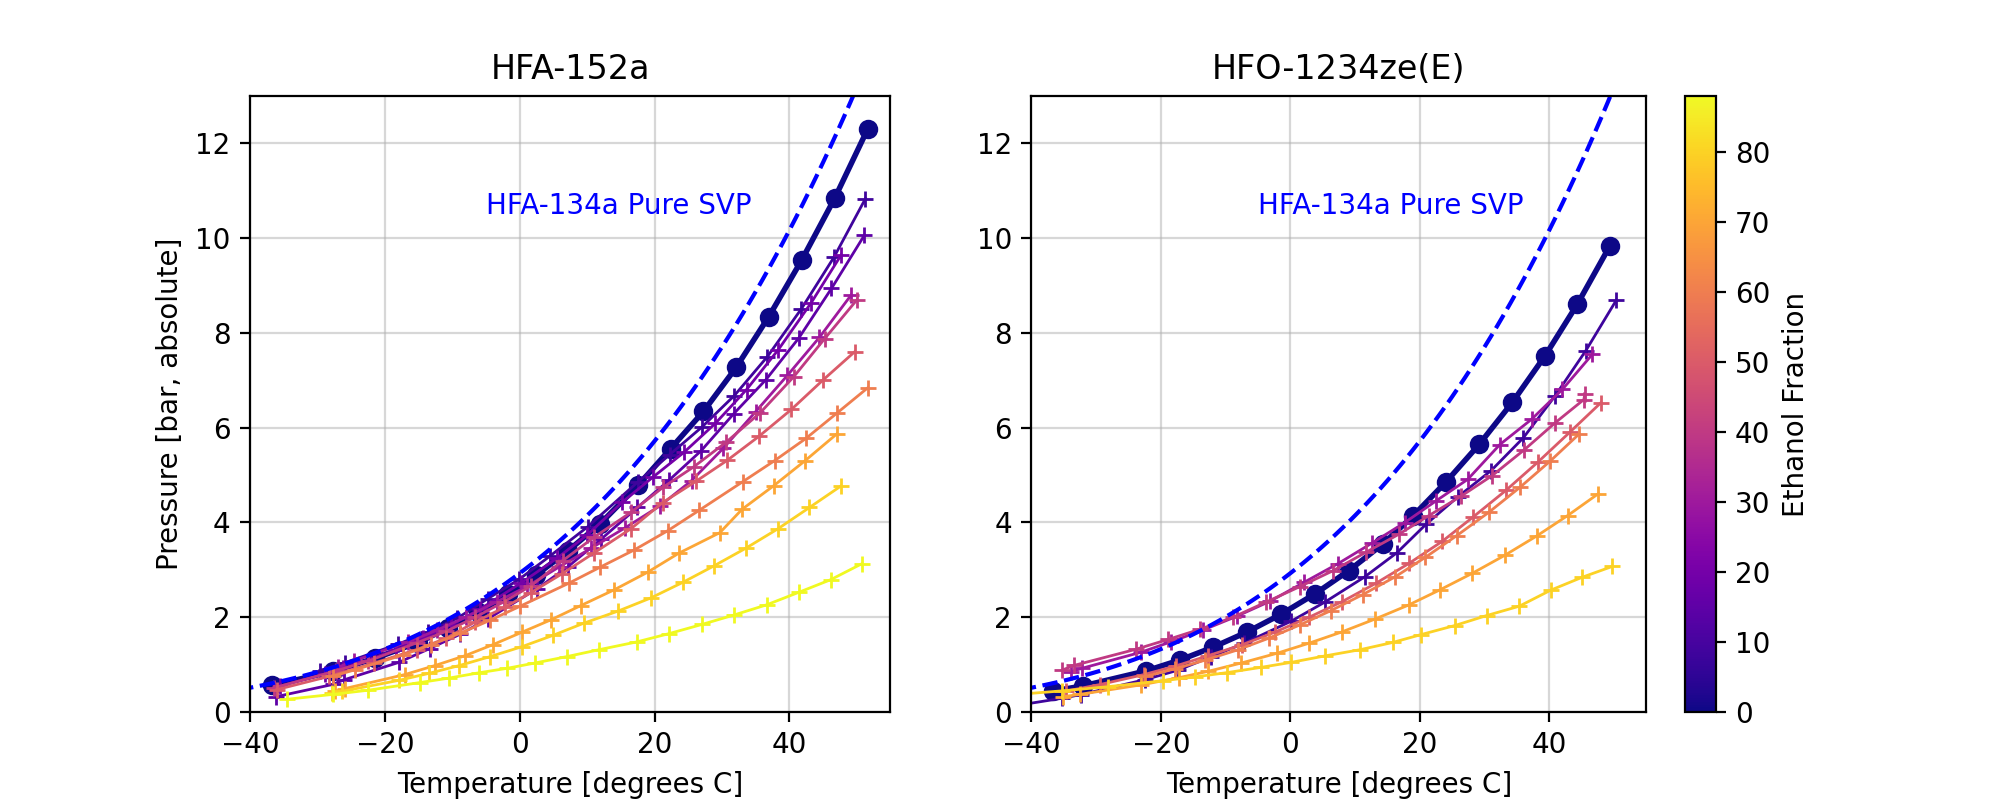

In [105]:
from matplotlib import gridspec

def production_line_plot(datasets, propellant='', i=0, gridSpec=None, refDataset=None, maxEthanol=88):
    # Set up a colour scheme 
    cmap=plt.cm.plasma
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=maxEthanol))

    # Make figure - CORRECTED TEMPERATURE
    if gridSpec is None: ax=fig.add_subplot(1,2,i+1)
    else: ax = plt.subplot(gridSpec[i])
    plt.grid(alpha=.5)
    plt.xlabel("Temperature [degrees C]")
    if i==0: plt.ylabel("Pressure [bar, absolute]")
    plt.title("%s" % propellant)
    
    # force common axes limits for all subplots
    plt.xlim(-40,55)
    plt.ylim(0,13)
    
    for dataset in datasets:
        lw=1; m='+'
        if (dataset['EthanolFraction']<=maxEthanol):
            if dataset['EthanolFraction'] <= 0: 
                lw=2
                m='o'
                
            ax.plot(dataset['Canister_Tcal_degC']-dataset['Tcal_correction'],\
                    dataset['Pressure_bar_abs']-dataset['Pressure_correction'],\
                     marker=m,lw=lw,\
                     c=cmap(dataset['EthanolFraction']/maxEthanol),\
                     label='%.1f%% Ethanol' % (dataset['EthanolFraction']))
            
            
        
    # reference condition
    if refDataset is not None:
        ax.plot(refDataset['NIST_Temp_degC'], refDataset['Pressure_bar_abs'],\
                 marker=None,ls='--',\
                 c='b', label='REFERENCE')
        plt.text(-5,10.5,refDataset['descriptor'],c='b')
        
    # color bar
    if i==1: plt.colorbar(sm,label='Ethanol Fraction',ax=ax);
        
fig=plt.figure(figsize=(10,4));
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])
production_line_plot(HFA152a_datasets,"HFA-152a",0,gs,HFA134a_NIST);
production_line_plot(HFO1234ze_datasets,"HFO-1234ze(E)",1,gs,HFA134a_NIST);
plt.savefig("/Users/dduke/Desktop/SVP_productionPlot.pdf")

## Plot an isotherm at room temperature

In [152]:
def make_iso(datasets,Temperatures_degC,corrected=True):
    
    # Get all data to 1D
    
    if corrected:
        all_P = np.concatenate([ dataset['Pressure_bar_abs']-dataset['Pressure_correction'] for dataset in datasets ])
        all_T = np.concatenate([ dataset['Canister_Tcal_degC']-dataset['Tcal_correction'] for dataset in datasets ])
    else:
        all_P = np.concatenate([ dataset['Pressure_bar_abs'] for dataset in datasets ])
        all_T = np.concatenate([ dataset['Canister_Tcal_degC'] for dataset in datasets ])
    
    all_E = np.concatenate([ dataset['EthanolFraction']*np.ones_like(dataset['Pressure_bar_abs'])  for dataset in datasets ])

    # Make coordinate grid to interpolate onto.
    eth = [ dataset['EthanolFraction'] for dataset in datasets ]
    temp = Temperatures_degC
    tt, ee = np.meshgrid(temp, eth)
    
    # Interpolate using Delaunay triangulation
    L1=scipy.interpolate.LinearNDInterpolator([(all_T[n], all_E[n]) for n in range(len(all_T))], all_P)
    pts = [(tt.ravel()[n], ee.ravel()[n]) for n in np.arange(np.product(ee.shape))]

    return ee, L1(pts).reshape(ee.shape)

<IPython.core.display.Javascript object>


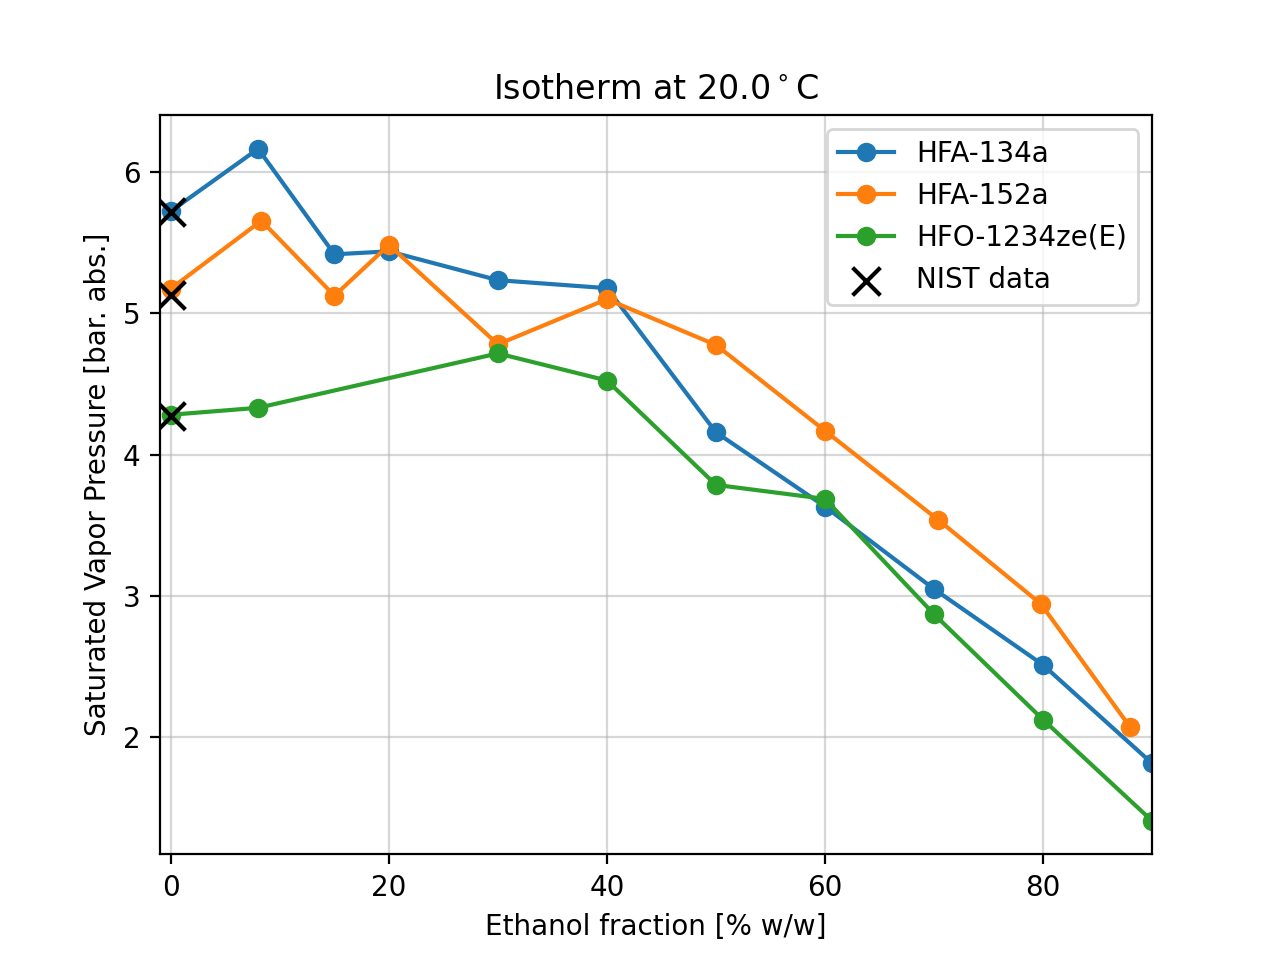

In [163]:
temps_degC = np.array((20,))

# Interpolate empirical data 
iso_152_e, iso_152_p = make_iso(HFA152a_datasets, temps_degC)
iso_134_e, iso_134_p = make_iso(HFA134a_datasets, temps_degC)
iso_1234_e, iso_1234_p = make_iso(HFO1234ze_datasets, temps_degC)

# Interpolate NIST
NIST_Pressure = np.array([ np.interp(temps_degC,HFA134a_NIST['NIST_Temp_degC'],HFA134a_NIST['Pressure_bar_abs']),\
                 np.interp(temps_degC,HFA152a_NIST['NIST_Temp_degC'],HFA152a_NIST['Pressure_bar_abs']),\
                 np.interp(temps_degC,HFO1234_NIST['NIST_Temp_degC'],HFO1234_NIST['Pressure_bar_abs']) ])

fig=plt.figure()
plt.grid(alpha=.5)
plt.xlabel("Ethanol fraction [% w/w]")
plt.ylabel("Saturated Vapor Pressure [bar. abs.]")
plt.xlim(-1,90)
plt.plot(iso_134_e, iso_134_p, marker='o', label='HFA-134a')
plt.plot(iso_152_e, iso_152_p, marker='o', label='HFA-152a')
plt.plot(iso_1234_e, iso_1234_p, marker='o', label='HFO-1234ze(E)')

plt.scatter(NIST_Pressure*0, NIST_Pressure, label='NIST data', marker='x', c='k', s=100, zorder=99)
plt.legend();
if len(temps_degC) == 1:
    plt.title("Isotherm at $%.1f^\circ$C" % temps_degC)
else:
    plt.title("Isotherm at $%s^\circ$C" % ','.join([str(t_) for t_ in temps_degC]))

## Write spreadsheet

In [ ]:
...